# Linear Regression
Regression is an approach to finding function $f(x)$, that models the conditional expectation of $Y$ given X:

$$
f(x) = E[Y|X=x]
$$

In linear regression, we assume that this function is globally linear (see [parent README.md](../README.md) for the meaning of this.).

In regression, minimizing the sum of square residuals by finding the the minimizing set of parameters is called the least squared solution,
and the regression function when viewed in a statistical sense is the solution to least squares.

For linear regression,there is an analytical solution derived from linear algebra:
$$
\hat{\vec{b}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T*\vec{y}
$$

Alternatively, when direct matrix inversion is computationally prohibitive (due to its cubic complexity in the number of features, O(p³)), iterative methods like (mini-)batch gradient descent are preferred (O(np) per iteration). This is where we estimate the gradient using the minibatch.

While the analytical solution, in its purest form, requires a global computation on the entire dataset, making it difficult to directly parallelize in the same way as gradient descent is and the tool ecosystem is very mature for optimizing in this way.

Assume here * refers to matrix multiplication, unless otherwise noted.


$$
Loss = (\vec{y} - \mathbf{X}\vec{b})^T(\vec{y} - \mathbf{X}\vec{b}) \\
\forall (\forall \mathbf{X}_{b} \in \mathbf{X}) \in N_{trainiter} \\
\hat{\vec{b}} = \hat{\vec{b}} + \alpha * 1/M *\nabla_{\hat{\vec{b}}} Loss \\
\hat{\vec{b}} = \hat{\vec{b}} + \alpha * 1/M * 2\mathbf{X}_b^T*(\vec{y} - \mathbf{X}_b \hat{\vec{b}})
$$

## Assumptions:
* Can have additive error, $ y = f(x) + \epsilon $, and uncorrelated with x ( $\epsilon \perp X$) constant variance and usually $\epsilon  \sim N(0,\sigma^2)$. This helps for further statistical analysis.
* Globally linear f(x)

## Example:
Lets generate some data using a linear model with additive error, and use both the gradient based and analytical model to see if we can get the original parameters.


In [1]:
import numpy as np

coefficients = np.array([0.1, 5]).T
bias = np.array([3])

noise = np.random.normal(0, 1, (1000))

input = np.random.uniform(-1.0, 1.0, (1000, 2))

output = noise + input @ coefficients + bias

/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1685306300.py:10: RuntimeWarning: divide by zero encountered in matmul
  output = noise + input @ coefficients + bias
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1685306300.py:10: RuntimeWarning: overflow encountered in matmul
  output = noise + input @ coefficients + bias
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1685306300.py:10: RuntimeWarning: invalid value encountered in matmul
  output = noise + input @ coefficients + bias


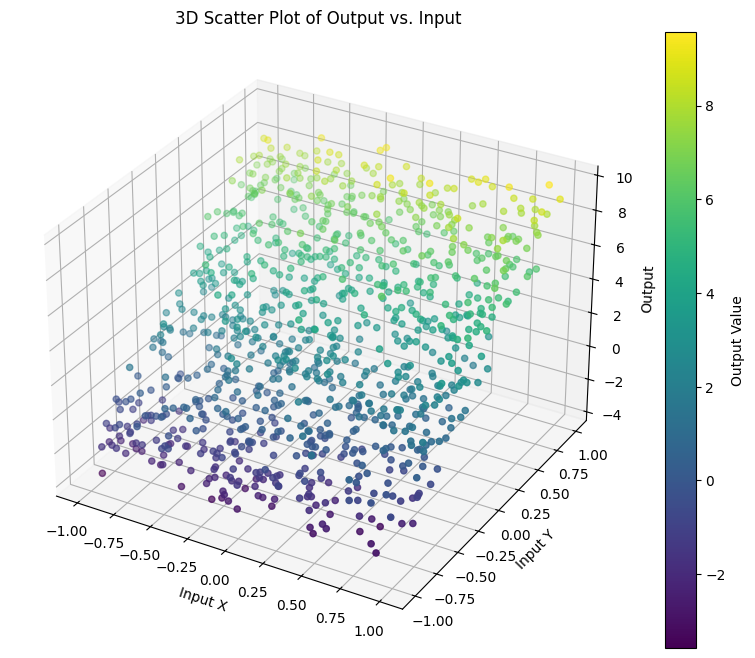

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(input[:, 0], input[:, 1], output, c=output, cmap='viridis', marker='o')
ax.set_xlabel("Input X")
ax.set_ylabel("Input Y")
ax.set_zlabel("Output")
ax.set_title("3D Scatter Plot of Output vs. Input")
fig.colorbar(scatter, label="Output Value")
plt.show()

In [3]:
# analytical approach:
inputWithBias = np.hstack([input, np.ones((input.shape[0], 1))])
def analyticalLinearRegression(inputWithBias, output, debug=True):
    coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
    mse = np.sum((output - inputWithBias @ coefficientsEstimateAnalytical) ** 2) / output.shape[0]
    if debug:
        print(f"mse: {mse}")
    return coefficientsEstimateAnalytical
coefficientsEstimateAnalytical = analyticalLinearRegression(inputWithBias, output)
print(f"Estimated coefficients: {coefficientsEstimateAnalytical[:-1]}, true coefficients: {coefficients}")
print(f"Estimated bias: {coefficientsEstimateAnalytical[-1]}, true bias: {bias}")

mse: 0.9162254573299474
Estimated coefficients: [0.05343984 5.07641925], true coefficients: [0.1 5. ]
Estimated bias: 3.02774601832846, true bias: [3]


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: divide by zero encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: overflow encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: invalid value encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:5: RuntimeWarning: divide by zero encountered in matmul
  mse = np.sum((output - inputWithBias @ coefficientsEstimateAnalytical) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv44000

In [4]:
# gradient based approach:
def gradientBasedLinearRegression(inputWithBias, output, debug=True):
    coefficientsEstimateGradient = np.random.normal(0, 1, (3))
    batchSize = 10
    learningRate = 0.01
    epochs = 10
    for epoch in range(epochs):
        for batch in range(inputWithBias.shape[0] // batchSize):
            batchInput = inputWithBias[batchSize * batch : batchSize * batch + batchSize]
            batchOutput = output[batchSize * batch : batchSize * batch + batchSize]
            coefficientsEstimateGradient += learningRate * 1 / batchInput.shape[0] * 2 * batchInput.T @ (batchOutput - batchInput @ coefficientsEstimateGradient)
        epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
        if debug==True:
            print(f"end epoch {epoch + 1}, mse: {epochalMSE}")
    return coefficientsEstimateGradient
coefficientsEstimateGradient = gradientBasedLinearRegression(inputWithBias, output)

end epoch 1, mse: 1.9622540190513555
end epoch 2, mse: 1.1513176777326364
end epoch 3, mse: 0.9776601168511277
end epoch 4, mse: 0.9332686186259024
end epoch 5, mse: 0.9216777035487546
end epoch 6, mse: 0.9186081926539655
end epoch 7, mse: 0.9177779127380383
end epoch 8, mse: 0.9175456341000872
end epoch 9, mse: 0.9174772496832095
end epoch 10, mse: 0.9174556578473998


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2827835301.py:12: RuntimeWarning: divide by zero encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2827835301.py:12: RuntimeWarning: overflow encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2827835301.py:12: RuntimeWarning: invalid value encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]


In [5]:
print(f"gradient coefficients + intercept: {coefficientsEstimateGradient}, and analytical{ coefficientsEstimateAnalytical}")

import statsmodels.formula.api as smf
import pandas as pd
df = pd.DataFrame(input, columns=['feature_1', 'feature_2'])
df['target_output'] = output
formula = 'target_output ~ feature_1 + feature_2'
model_formula = smf.ols(formula=formula, data=df)
results_formula = model_formula.fit()
print("\n--- Statsmodels OLS Results---")
print(results_formula.params)

gradient coefficients + intercept: [0.07156232 5.07020946 2.99452595], and analytical[0.05343984 5.07641925 3.02774602]

--- Statsmodels OLS Results---
Intercept    3.027746
feature_1    0.053440
feature_2    5.076419
dtype: float64


This shows they get to the same place.

## Goodness of fit
The goal of goodness-of-fit tests in linear regression is to assess how well the model's assumptions hold and whether the model adequately captures the relationship between the predictors and the response. This goes beyond just minimizing the loss function; it's about ensuring the validity of the model and its interpretations.

The fundamental approach is to use a model output ($\hat{\vec{y}}$) vs residual ($\hat{\vec{y}} - \vec{y}$) plot, this is expected to be a random scatter centered around 0.

If it's not (e.g., a curved pattern or a non-constant variance (not Homoscedasticity)) one can dig further to see which features are non linear by considering feature vs residual plot. 

One could then try to transform the feature/output to have a more linear relationship, or consider another model.


### For interpretability
It's important for interpretability and to make inferences about coefficients to look at and check for multi-colinearity and to look at and check for normality of errors.

#### Multi - collinearity
This violates one of the assumptions that each feature is independent from another $P(X_i | X_j) = P(X_i), \forall i, j$ where $i \neq j$.

Two approaches:

##### VIF
VIF is the Variance Inflation Factor (VIF). It is performing linear regression treating the feature for which you are finding the VIF for as dependent varaible to be predicted by all the other features, then computing $ 1 / (1 - R^2)$ for this model. $R^2$ is 1 - sum of square residuals / total sum of squares, it compares how off we are from predicting the feature over a baseline of just using the average, where 1 means the model is 0 error, than just predicting and 0 means the model explains none of the variance in the VIF feature; it's no better than simply predicting the mean, then The VIF is the reciprocal of (1 - R²), which quantifies how well the model could get on without the feature (since it could be linearly constructed from the others). R² larger is smallest error, so then 1 - R² flips this and reciprical flips it again and R² then larger is smaller error, which would mean that the feature is redundant.

We compute VIFs for each feature and A VIF > 5 (or 10, depending on the context) suggests problematic multicollinearity.

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

After you find features with VIFs, you can look at correlation matrix to find the variables that you can consider dropping then recheck for VIF values. You don't necessarily have to do this for just prediction usage but for interpretability of the coefficients. You could also combine them (average or otherwise), or even use regularization though the simple interpretability that came from the assumptions of independent factors is not valid anymore.

##### Correlation matrix
One could also directly examine the correlation matrix of the predictors. The correlation matrix is derived from covariance matrix, its the covariance matrix divided by the product of the standard deviations of the two variables in each pair- it normalizes the covariance so its always between -1 and 1, removing the scaling differences that would otherwise make covariance a good option to compare how features "move together" which is the condition of multi collinearity that we seek.

Pairwise correlation:
$\rho_{jk} = \frac{\sum_{i=1}^{n} (x_{ij} - \bar{x}_j)(x_{ik} - \bar{x}_k)}{\sigma_i * \sigma_j}$


Efficient Linear Algebra for correlation matrix:


$$
\vec{\bar{x}} = average(\mathbf{X}, dim=0).reshape(1, \mathbf{X}.shape[1]) \\
\mathbf{X_{demenaed}} = \mathbf{X} -\vec{\bar{x}} \\ 
Cov = (\mathbf{X_{demeaned}}^T*\mathbf{X_{demeaned}}) / (\mathbf{X}.shape[0] - 1) \\
StdDevInv = 1 / sqrt(diagnol(Cov)) \\
Correlation = Cov *_{element} StdDevInv.reshape(1,\mathbf{X}.shape[1]) *_{element} StdDevInv.reshape(\mathbf{X}.shape[1], 1)
$$

Here we make use of broadcasting, as Numpy implements it.

Look for high pairwise correlations (e.g., |r| > 0.8 or 0.9), remove those with very high.

#### Normality of errors
To see whether errors are normal, one could plot them with a histogram and see if it's the traditional bell shaped curve, centered around 0 or use normal Q-Q (Quantile - Quantile) plot, where you plot values in Y axis and the standard normal z score for the porportion of sample values below that (altered a bit to avoid infinity z scores) (inverse CDF of standard normal). A 45-degree reference line from 0 is often added and how well the plotted points lines up and where indicate how standard normal the residuals actually are, a straight line indicates a linear relationship though the standard deviation and mean are the slope and offset respectively.

Tests like the Shapiro-Wilk test or Anderson-Darling test provide a p-value to formally test the null hypothesis that the residuals are normally distributed. However, visual inspection with histograms and especially Q-Q plots is often preferred, particularly for understanding *how* the distribution deviates from normality if it does.

If they're not, may want to transform the response variable, for example taking a $log(Y)$ is most common or square root (particulary if its right skew which means mean is greater than median), if it's left skew you can do $1 - log(y)$.

Or consider generalized linear models (GLMs) which do not assume normal 0 centered noise.

/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2842622616.py:2: RuntimeWarning: divide by zero encountered in matmul
  residuals = output - (inputWithBias @ coefficientsEstimateGradient)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2842622616.py:2: RuntimeWarning: overflow encountered in matmul
  residuals = output - (inputWithBias @ coefficientsEstimateGradient)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2842622616.py:2: RuntimeWarning: invalid value encountered in matmul
  residuals = output - (inputWithBias @ coefficientsEstimateGradient)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2842622616.py:3: RuntimeWarning: divide by zero encountered in matmul
  plt.scatter((inputWithBias @ coefficientsEstimateGradient), residuals)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2842622616.py:3: RuntimeWarning: overflow encountered in matmul
  plt.scatter((inputWithBias @ coefficientsEstimateGrad

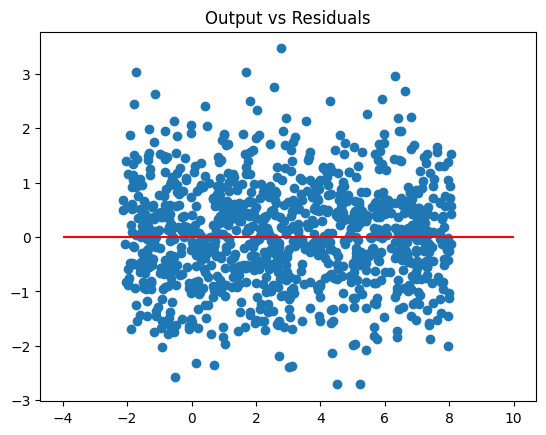

In [6]:
## goodness of fit
residuals = output - (inputWithBias @ coefficientsEstimateGradient)
plt.scatter((inputWithBias @ coefficientsEstimateGradient), residuals)
plt.hlines(0, -4, 10, colors="red")
plt.title("Output vs Residuals");

In [7]:
# looks pretty good, which it should, constant variance 0 noise was used to generate it
# for interpretability, lets do VIF
# VIF = 1 / (1 - R^2) for R^2 value of using other features used regress to feature we are getting VIF from
# R^2 = 1 - SSR / SST where SSR is sum(residuals^2) and SST is sum((y - mean(y))^2)
def VIF(featureIndex, modelInput):
    x = np.hstack([modelInput[:, :featureIndex], modelInput[:, featureIndex + 1:]])
    y = modelInput[:, featureIndex]
    xWithBias = np.hstack([x, np.ones((x.shape[0], 1))])
    coefficients = np.linalg.inv(xWithBias.T @ xWithBias) @ xWithBias.T @ y
    modelOutput = xWithBias @ coefficients
    ssr = np.sum((y - modelOutput)**2)
    residuals = y - modelOutput
    sst = np.sum((y - np.mean(y))**2)
    rSquared = 1 - ssr / sst
    return 1 / (1 - rSquared)

for i in range(input.shape[1]):
    print(f"VIF of index {i}: {VIF(i, input)}")

def correlationMatrix(modelInput):
    means = np.mean(modelInput, axis=0).reshape(1, modelInput.shape[1])
    demeanedX = modelInput - means
    covariance = (demeanedX.T @ demeanedX) / (modelInput.shape[0] - 1)
    standardDeviationInv = 1/ np.sqrt(np.diag(covariance))
    return covariance * standardDeviationInv.reshape(1, modelInput.shape[1]) * standardDeviationInv.reshape(1, modelInput.shape[1]) 

print("Correlation matrix:\n", correlationMatrix(input))

VIF of index 0: 1.000462748006603
VIF of index 1: 1.000462748006603
Correlation matrix:
 [[ 1.         -0.02137639]
 [-0.02163761  1.        ]]


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1324913310.py:10: RuntimeWarning: divide by zero encountered in matmul
  modelOutput = xWithBias @ coefficients
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1324913310.py:10: RuntimeWarning: overflow encountered in matmul
  modelOutput = xWithBias @ coefficients
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1324913310.py:10: RuntimeWarning: invalid value encountered in matmul
  modelOutput = xWithBias @ coefficients


In [8]:
# looks like the VIFs indicate a low multi collinearity
# also correlation matrix is pretty much identity
# which is expected
# Using numpy's built-in function
corr_matrix_np = np.corrcoef(input, rowvar=False)
# 'rowvar=False' means columns are variables, rows are observations
print("Correlation matrix (using np.corrcoef):\n", corr_matrix_np)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant # To add the intercept term

X_with_const = add_constant(input)
print("VIFs from statsmodels:\n", [variance_inflation_factor(X_with_const, i + 1) for i in range(input.shape[1])])

## so we are on track, though the correlation coefficient was off, its in the 4th decimal place in a value that ranges from -1 to 1
# so we will chalk it up to rounding errors and exact procedure

Correlation matrix (using np.corrcoef):
 [[ 1.        -0.0215066]
 [-0.0215066  1.       ]]
VIFs from statsmodels:
 [np.float64(1.000462748006603), np.float64(1.000462748006603)]


## Validation
While goodness-of-fit diagnostics check how well the model fits the data it was trained on and whether assumptions are met, validation focuses on estimating how well the model will perform on new, unseen data. This is crucial for understanding the model's generalization ability and avoiding overfitting, where the model learns noise specific to the training set rather than the underlying relationship.

There are a couple common ways to do this:
1. **Simple test / train split**: One randomly partitions the dataset into a train and test dataset. The train dataset is used to estimate the coefficients of the model and then the test dataset is used to estimate the generalization error (like MSE, or square root of MSE).This is simple but an unlucky split could give you a pessimistic or optimistic estimate of the generalization error.
2. **K-fold cross validation**: One randomly partitions the dataset into K chunks, K - 1 are used to train the model while 1 is used to estimate the generalization error. This is done for each of the K partitions and the estimate of the generalization error is more robust to a random partition's data (since one could look at it's average as a point estimate and it's spread to understand the stability of the generalization error). It does take more to compute. 


In [9]:
# split train and test
splitIndex = int(len(input)*0.8)
trainX = input[:splitIndex]
trainY = output[:splitIndex]

testX = input[splitIndex:]
testY = output[splitIndex:]

# train on train
trainWithBias = np.hstack([trainX, np.ones((len(trainX), 1))])
print("training gradient:")
estimatedCoefficientsGradient = gradientBasedLinearRegression(trainWithBias, trainY)
print()
print("training analytical:")
estimatedCoefficientsAnalytical = analyticalLinearRegression(trainWithBias, trainY)
print()
# validate on test:
print("validating on test:")
testWithBias = np.hstack([testX, np.ones((len(testX), 1))])
print()
print("analytical mse:")
print(((testWithBias @ estimatedCoefficientsAnalytical - testY)**2).sum() / len(testX))
print()
print("gradient mse:")
print(((testWithBias @ estimatedCoefficientsGradient - testY)**2).sum() / len(testX))

training gradient:
end epoch 1, mse: 4.606472084909014
end epoch 2, mse: 2.1131603633843796
end epoch 3, mse: 1.3332060996813808
end epoch 4, mse: 1.067726284030177
end epoch 5, mse: 0.9760431045114791
end epoch 6, mse: 0.944179293624536
end epoch 7, mse: 0.9330357755104238
end epoch 8, mse: 0.9291089840488805
end epoch 9, mse: 0.9277120382223429
end epoch 10, mse: 0.927209177994094

training analytical:
mse: 0.926277885636988

validating on test:

analytical mse:
0.877558080399327

gradient mse:
0.8752024632213437


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2827835301.py:12: RuntimeWarning: divide by zero encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2827835301.py:12: RuntimeWarning: overflow encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2827835301.py:12: RuntimeWarning: invalid value encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: divide by zero encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/

analytical:
0.9213177111099432
0.2137203943830687
gradient:
0.9217048662358073
0.21343065208132334


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2827835301.py:12: RuntimeWarning: divide by zero encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2827835301.py:12: RuntimeWarning: overflow encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2827835301.py:12: RuntimeWarning: invalid value encountered in matmul
  epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: divide by zero encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/

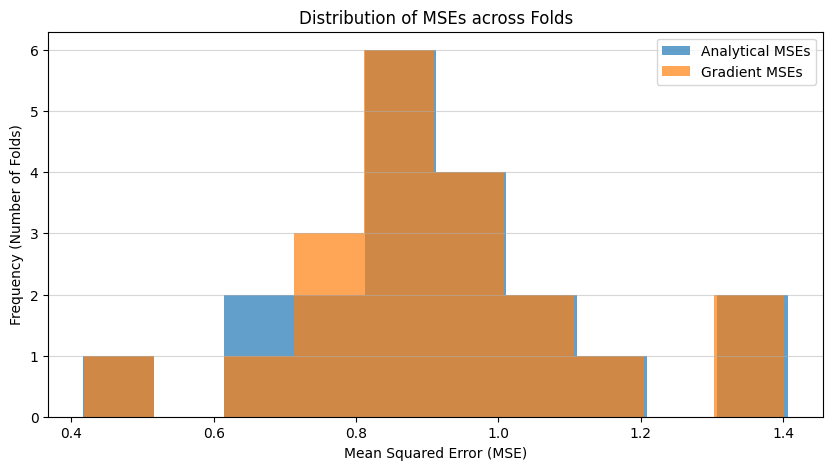

In [10]:
# k fold cross validation
# split everything
numFolds = 20
itemsPerFold =inputWithBias.shape[0] // numFolds
folds = []
targets = []
numIndices = inputWithBias.shape[0]

indices = np.random.permutation(numIndices)
outputMixed = output[indices]
inputWithBiasMixed = inputWithBias[indices]


folds = np.array_split(inputWithBiasMixed, numFolds)
targets = np.array_split(outputMixed, numFolds)
# for each do the process infer on the iterated fold
mses = []
for foldIndex, fold in enumerate(folds):
    trainX = np.vstack([folds[x] for x in range(len(folds)) if x != foldIndex])
    trainY = np.hstack([targets[x] for x in range(len(targets)) if x != foldIndex])

    testX = fold
    testY = targets[foldIndex]
    estimatedCoefficientsGradient = gradientBasedLinearRegression(trainX, trainY, debug=False)
    estimatedCoefficientsAnalytical = analyticalLinearRegression(trainX, trainY, debug=False)
    mse = (((testX @ estimatedCoefficientsAnalytical - testY)**2).sum() / len(testX), ((testX @ estimatedCoefficientsGradient - testY)**2).sum() / len(testX))
    mses.append(mse)
# average, capture spread, maybe distribution
plt.figure(figsize=(10, 5))
print("analytical:")
print(np.array([m[0] for m in mses]).mean())
print(np.array([m[0] for m in mses]).std())
plt.hist([m[0] for m in mses],  alpha=0.7, label='Analytical MSEs')

print("gradient:")
print(np.array([m[1] for m in mses]).mean())
print(np.array([m[1] for m in mses]).std())
plt.hist([m[1] for m in mses],  alpha=0.7, label='Gradient MSEs')
plt.title('Distribution of MSEs across Folds')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency (Number of Folds)')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

plt.show()

# Model Complexity
Model complexity for linear regression can be controlled by both regularization and feature selection. Both of these reduce the variance (sensitivty to the training data) and introduce a bias.

## Regularization
Regularization introduces a penalty based on coefficient size. This penalty helps reduce model variance and improve generalization error, especially when dealing with multicollinearity or high-dimensional data. However, it makes direct interpretation of the coefficients harder because it introduces bias, shrinking them towards 0 compared to the OLS estimates.

Since the penalty is applied to the coefficient size, it's crucial to standardize features (e.g., subtract mean, divide by standard deviation) before applying regularization. This ensures features are on a comparable scale and the penalty is applied fairly, rather than being influenced by arbitrary units. Standardization adds a layer to interpretation, as coefficients then relate to changes in standard deviations of the predictors.

Also regularization excludes the intercept (or bias) term since this term isn't a measure of sensitivity to the features as the feature coefficients are, and the bias term itself is origin-dependent (really the baseline, if all coefficients are zero), and penalizing it would undesirably tie the regularization outcome to the choice of origin (or data centering), which is generally not the goal. The goal is to penalize feature sensitivity (slopes), not the overall offset (intercept).

There are two types of regularization adding either or both to $ sum((Y - \mathbf{X}\Beta)^2)$:
1. Lasso regularization or adding a $\lambda * \sum_i|\beta_i|$. Lasso stands for least absolute shrinkage and selection operator. If you look at the slope for absolute value compared to L2 (quadratic) the slope is stronger as you get closer to 0, therefore it tends to shrink coefficients and produce sparse models. Cannot be solved in analytical closed form, use proximal gradient descent (split the coefficient update into two):
    1. The gradient descent normal update (as described above in this notebook). Let's say this gives you $\vec{z}$.
    2. Proximal update, which is $\beta_j = sign(z_j)*max(|z_j| - \eta, 0)$, this essentially drives the ceofficient closer to 0 if it's not already in some threshold within 0. $η=α*\lambda$. Proximal gradient descent has been shown to be convex.


2. Ridge regularizaton or adding a $\lambda * \sum_i\beta_i^2$. Ridge is named that because its equivalent to adding a $\lambda*\mathbf{I}$ to the matrix before inverting, which looks like a series of peaks. It forces correlated predictors to "share" the credit because fo the quadratic nature. Instead of one coefficient becoming huge positive and a correlated one huge negative, Ridge tends to shrink both of their coefficients towards each other and towards zero. Can be solved analytical closed form as well: $\hat{\mathbf{b}}_{\text{Ridge}} = (\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$, as well as gradient descent (gradient is only different $\nabla_{\beta} L_{\text{Ridge}}(\beta) = -2\mathbf{X}^T(Y - \mathbf{X}\beta) + 2\lambda\beta$).


3. Mix Lasso and ridge for elastic net regression, using a single $\alpha$ for both and ratio ($\rho$) of L1 and L2. so it would be $\alpha*(\rho*\sum_i|\beta_i| + (1-\rho)*1/2*\sum_i\beta_i^2)$. This would similarily be optimized using proximal gradient descent:
    1. The gradient descent normal update (as described above in this notebook) with the L2 regularization parameter ($(1-\rho)*1/2$). Let's say this gives you $\vec{z}$.
    2. Proximal update, which is $\beta_j = sign(z_j)*max(|z_j| - \eta, 0)$, this essentially drives the ceofficient closer to 0 if it's not already in some threshold within 0. $η=α*\lambda$

Generally the weights add a retriction on the coefficient space that's being searched, in the bias variance decomposition $E[(y - \mathbf{x}.T\beta)^2] = bias^2 + Variance + \sigma^2$, bias is increased, but variance is reduced as well, so you can end up with a more stable estimate, thats not so dependent on the training data (less sensitive).

When searching for hyperparameters one could take the training set and further split it into a validation and training set, where the training set is used to train the parameters, and the validation set is used to find the best hyper parameters. or partition the dataset into a train (80-90%) and test, then on the train perform k-fold validation to find best hyper parameters, retrain on entire training set and report the test set performance of thsi model as the generalization error.


In [11]:
# lets standardize
inputStd = (input - input.mean(0)) / input.std(0)

# need to transform the y too to remove bias
outputDemeaned = output - output.mean()

In [12]:
n = 57
np.eye(n) @ inputStd[57 - n:57].astype(np.float64)
print("Runtime error")
# numpy bug: RuntimeWarning: invalid value encountered in matmul
# https://github.com/numpy/numpy/issues/28687 

Runtime error


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/246870512.py:2: RuntimeWarning: divide by zero encountered in matmul
  np.eye(n) @ inputStd[57 - n:57].astype(np.float64)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/246870512.py:2: RuntimeWarning: overflow encountered in matmul
  np.eye(n) @ inputStd[57 - n:57].astype(np.float64)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/246870512.py:2: RuntimeWarning: invalid value encountered in matmul
  np.eye(n) @ inputStd[57 - n:57].astype(np.float64)


In [13]:
# ridge regression (L2):
def ridgeRegressionAnalytical(inputStd, y, strength = 1):
    return np.linalg.inv(inputStd.T @ inputStd + strength*np.identity(inputStd.shape[1])) @ inputStd.T @ y

print(f"Ridge regression analytical solution:{ridgeRegressionAnalytical(inputStd, outputDemeaned)}")
print(f"train mse: {((inputStd @ ridgeRegressionAnalytical(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

def ridgeRegressionGradient(x, y, strength = 1, learningRate=.001, epochs=1000, batchSize = 10, debug=True ):
    coefficientsEstimate = np.random.standard_normal(((2)))
    splitX = np.array_split(x, x.shape[0] // batchSize)
    splitY = np.array_split(y, x.shape[0] // batchSize)
    for e in range(epochs):
        for batchIndex in range(len(splitX)):
            batchInput = splitX[batchIndex]
            batchOutput = splitY[batchIndex]
            coefficientsEstimate += learningRate*2/ batchInput.shape[0] * batchInput.T@(batchOutput - batchInput @ coefficientsEstimate) - learningRate * 2 * strength * coefficientsEstimate / (x.shape[0] / batchInput.shape[0])
    return coefficientsEstimate

print(f"Ridge regression gradient solution: {ridgeRegressionGradient(x=inputStd, y=outputDemeaned)}")
print(f"train mse: {((inputStd @ ridgeRegressionGradient(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

Ridge regression analytical solution:[0.03063372 2.93374614]
train mse: 0.9162340729854822 
Ridge regression gradient solution: [0.03287095 2.90711061]


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1170723015.py:6: RuntimeWarning: divide by zero encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionAnalytical(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1170723015.py:6: RuntimeWarning: overflow encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionAnalytical(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1170723015.py:6: RuntimeWarning: invalid value encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionAnalytical(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")


train mse: 0.9171072393244187 


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1170723015.py:20: RuntimeWarning: divide by zero encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionGradient(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1170723015.py:20: RuntimeWarning: overflow encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionGradient(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1170723015.py:20: RuntimeWarning: invalid value encountered in matmul
  print(f"train mse: {((inputStd @ ridgeRegressionGradient(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")


In [14]:
print(f"Ridge regression gradient solution: {ridgeRegressionGradient(x=inputStd, y=outputDemeaned, strength=1)}")
print(f"Ridge regression analytical solution:{ridgeRegressionAnalytical(inputStd, outputDemeaned, strength=1)}")

Ridge regression gradient solution: [0.03287095 2.90711061]
Ridge regression analytical solution:[0.03063372 2.93374614]


In [15]:
print(f"Ridge regression gradient solution: {ridgeRegressionGradient(x=inputStd, y=outputDemeaned, strength=100)}")
print(f"Ridge regression analytical solution:{ridgeRegressionAnalytical(inputStd, outputDemeaned, strength=100)}")
# looks like the difference is even more pronounced as strenght goes up.
# I guess the reason is because additional hyper parameters for learning rate and epochs, though not entirely a satisfying outcome.

Ridge regression gradient solution: [0.00671687 1.46902235]
Ridge regression analytical solution:[0.02271134 2.66955409]


In [16]:
def lassoRegression(x, y, strength = 1, learningRate=.001, epochs=1000, batchSize = 10, debug=True ):
    coefficientsEstimate = np.random.standard_normal(((2)))
    splitX = np.array_split(x, x.shape[0] // batchSize)
    splitY = np.array_split(y, x.shape[0] // batchSize)
    for e in range(epochs):
        for batchIndex in range(len(splitX)):
            batchInput = splitX[batchIndex]
            batchOutput = splitY[batchIndex]
            coefficientsEstimate += learningRate*2/ batchInput.shape[0] * batchInput.T@(batchOutput - batchInput @ coefficientsEstimate)
            # lasso update
            threshold = learningRate*strength
            coefficientsEstimate = np.sign(coefficientsEstimate)*np.maximum(np.abs(coefficientsEstimate) - threshold, 0)
    return coefficientsEstimate

print(f"Lasso regression solution: {lassoRegression(x=inputStd, y=outputDemeaned)}")
print(f"train mse: {((inputStd @ lassoRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

def elasticNetRegression(x, y, strength = 1, l1Ratio = 0.5, learningRate=.001, epochs=1000, batchSize = 10, debug=True ):
    coefficientsEstimate = np.random.standard_normal(((2)))
    splitX = np.array_split(x, x.shape[0] // batchSize)
    splitY = np.array_split(y, x.shape[0] // batchSize)
    for e in range(epochs):
        for batchIndex in range(len(splitX)):
            batchInput = splitX[batchIndex]
            batchOutput = splitY[batchIndex]
            # ridge update
            coefficientsEstimate += learningRate*2/ batchInput.shape[0] * batchInput.T@(batchOutput - batchInput @ coefficientsEstimate) - 1/2 * (1-l1Ratio) * learningRate * 2 * strength * coefficientsEstimate / (x.shape[0] / batchInput.shape[0])
            # lasso update
            threshold = learningRate*strength*l1Ratio
            coefficientsEstimate = np.sign(coefficientsEstimate)*np.maximum(np.abs(coefficientsEstimate) - threshold, 0)
    return coefficientsEstimate
print(f"Elastic Net regression solution: {elasticNetRegression(x=inputStd, y=outputDemeaned)}")
print(f"train mse: {((inputStd @ elasticNetRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

Lasso regression solution: [-0.          2.43611787]


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/3199510095.py:16: RuntimeWarning: divide by zero encountered in matmul
  print(f"train mse: {((inputStd @ lassoRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/3199510095.py:16: RuntimeWarning: overflow encountered in matmul
  print(f"train mse: {((inputStd @ lassoRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/3199510095.py:16: RuntimeWarning: invalid value encountered in matmul
  print(f"train mse: {((inputStd @ lassoRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")


train mse: 1.1670723983788391 
Elastic Net regression solution: [-0.          2.67916436]
train mse: 0.9831445623965389 


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/3199510095.py:33: RuntimeWarning: divide by zero encountered in matmul
  print(f"train mse: {((inputStd @ elasticNetRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/3199510095.py:33: RuntimeWarning: overflow encountered in matmul
  print(f"train mse: {((inputStd @ elasticNetRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/3199510095.py:33: RuntimeWarning: invalid value encountered in matmul
  print(f"train mse: {((inputStd @ elasticNetRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")


## Feature Selection
For the sake of generalization (less degrees of freedom for the optimization to use to overfit), and interpretability (removing redundant features), it may be of use to find an ideal minimal subset of features that gets an acceptable performance.
This can also be viewed as a kind of regularization (discussed earlier) though in a discrete way, rather than continously as discussed in previous methods - an entire feature is removed not just coefficient adjusted.

Though for a subset size of n there are $2^n$ combinations of features to try. Which can be come prohibitive quickly. Practically, this is done in a greedy fashion either from the full set down to just an intercept or building up and selecting a feature to add one at a time, which is quadratic $O(p^2)$ in number of fits, which may not find the optimal subset, but has been empirically shown to be close.

To decide the best subset, one can use p-values (though more brittle since assumptions of feature independence are likely violated), or an information criteria like AIC or validation performance.

There are two ways to do this:
1. Forward stepwise - fit an intercept, then add the "best" feature next.
2. Backward stepwise - start will full set of features regression, remove feature that is "worst".

AIC is Akaike Information Criterion. It tries to capture a measure of generalization performance by including goodness of fit and model complexity:

$AIC = 2k - 2log(L)$

Linear model with additive normal 0 centered noise with constant variance:

$log(L) = -n/2log(2pi) - n/2log(\sigma^2) - 1/(2\sigma^2)*\sum_i e_i^2$

This is minimized.

In [17]:
x = np.arange(0,9).reshape(3,3)
x[:, [1,0]]

array([[1, 0],
       [4, 3],
       [7, 6]])

In [18]:
def AICModel(input, output):
    features = set(list(range(1, input.shape[1]))) # features to try (pooled)
    bestFeatures = [0]
    weights = analyticalLinearRegression(input[:, [(0)]], output)
    bestWeights = weights
    estimate = input[:, [(0)]] @ weights
    sse = (estimate - output) @ (estimate - output)
    n = input.shape[0]
    varEstimate = sse / n 
    k = 2
    logLikelihood = -n / 2 * np.log(2*np.pi) - n / 2 * np.log(varEstimate) - 1/2/varEstimate*sse
    AIC = 2*k - 2*logLikelihood
    while features:
        oldAIC = AIC
        bestFeature = -1
        for featureIndex in features:
            weights = analyticalLinearRegression(input[:, bestFeatures + [featureIndex]], output)
            estimate = input[:, bestFeatures + [featureIndex]] @ weights
            sse = (estimate - output) @ (estimate - output)
            n = input.shape[0]
            varEstimate = sse / n 
            kTemp = k + 1
            logLikelihood = -n / 2 * np.log(2*np.pi) - n / 2 * np.log(varEstimate) - 1/2/varEstimate*sse
            AICForThisModel = 2*kTemp - 2*logLikelihood
            if AICForThisModel < AIC:
                AIC = AICForThisModel
                bestFeature =  featureIndex
                bestWeights = weights
        if AIC == oldAIC:
            break
        bestFeatures.append(bestFeature)
        features.remove(bestFeature)
        k += 1
    return AIC, bestWeights, bestFeatures
        

AICModel(inputWithBias, output)

mse: 18.225540985324216
mse: 10.074838415221173
mse: 9.536337115999885
mse: 0.9162254573299475


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: divide by zero encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: overflow encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: invalid value encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/84022469.py:7: RuntimeWarning: divide by zero encountered in matmul
  sse = (estimate - output) @ (estimate - output)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/84022469.py:7: RuntimeWarni

(np.float64(2758.3842542719894),
 array([0.05343984, 3.02774602, 5.07641925]),
 [0, 2, 1])

## Interpretability
The biggest allure to linear regression is it's interpetability. Holding everything else constant a unit change in some covariate correlates with an increase in the response by the coefficient of that covariate. For dummy encodec categorical variables the coefficients for these k-1 dummy variables are then interpreted as the average effect or difference in the outcome variable compared to the baseline (the omitted category), holding all other variables constant.

The intercept is the solution if all covariates are zero.

If the input is standardized, then its a change in the standard deviation of the covariate.

However this only holds if the assumptions we've discussed so far are valid:

1. Linearity - the relationship is a linear one between covariate and response - (Check with residual plots).
1. Independent features - the features are independent among themselves, not correlated as that would offend the assumption of holding everything else constant - (Check VIFs).
1. No regularization - regularization adds a bias to make the coefficients smaller (and depending on type can move coefficients differently).
You've done an excellent job capturing the essence of these transformations! Your understanding is very strong. The statements just need a few minor tweaks for perfect precision and clarity, which is a common final polishing step.

You can apply transformations to your features or your output variable to better meet the assumptions of linear regression, but you must adjust your interpretation accordingly. Here are the common scenarios:

*   **Log-Log Model** ($\log(Y) \sim \log(X)$):
    *   **What it is:** Both the dependent variable ($Y$) and the independent variable ($X$) are log-transformed.
    *   **Interpretation:** The coefficient, $\beta$, represents an **elasticity**. A **1%** increase in the input ($X$) is associated with an approximate **$\beta$%** change in the output ($Y$).

*   **Log-Level Model** ($\log(Y) \sim X$):
    *   **What it is:** Only the dependent variable ($Y$) is log-transformed. The predictor ($X$) is in its original "level" scale.
    *   **Interpretation:** For a **one-unit** increase in the input ($X$), the output ($Y$) is expected to change by a multiplicative **factor of $\exp(\beta)$**. This translates to an approximate **$(\beta \times 100)\%$** change, or more precisely, a **$(\exp(\beta) - 1) \times 100\%$** change.

*   **Level-Log Model** ($Y \sim \log(X)$):
    *   **What it is:** Only the independent variable ($X$) is log-transformed. The output ($Y$) is in its original "level" scale.
    *   **Interpretation:** For a **1%** increase in the input ($X$), the output ($Y$) is expected to change by an absolute amount of **$(\beta / 100)$ units**.

*   **Level-Level Model** ($Y \sim X$):
    *   **What it is:** No log transformations on $X$ or $Y$.
    *   **Interpretation:** For a **one-unit** increase in the input ($X$), the output ($Y$) is expected to change by an absolute amount of **$\beta$ units**.
    

Transforming may help with better conforming to (linearity). See Feature Engineering section for a process.

### Statistically
From a statistical point of view, with the following additional assumptions, we can start to make inferential statements (confidence bands) about the true coefficient (s) and about the response.

1. Additive zero meaned gaussian noise with constant variance (Check with residual plots).

#### Coefficient Inferences

To get the standard error (which lets us build confidence intervals), we need variance, which can be shown to be equal to:

$$
Var(\hat{\vec{\beta}} | \mathbf{X}) = \sigma^2 (\mathbf{X}^T\mathbf{X})^{-1}
$$

$$
s^2 = \hat{\sigma}^2 = \frac{RSS}{n - p - 1} = \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{n - p - 1} = \frac{(\vec{y} - \mathbf{X}\hat{\vec{\beta}})^T(\vec{y} - \mathbf{X}\hat{\vec{\beta}})}{n - p - 1}
$$

where `n` is the number of observations and `p` is the number of predictors (excluding the intercept). The term `n - p - 1` represents the degrees of freedom for the error estimate.

The estimated variance-covariance matrix of `β̂` is then:

$$
\hat{Var}(\hat{\vec{\beta}} | \mathbf{X}) = s^2 (\mathbf{X}^T\mathbf{X})^{-1}
$$

The **Standard Error (SE)** for an individual coefficient estimate `β̂ⱼ` is the square root of the j-th diagonal element of this estimated variance-covariance matrix:

$$
SE(\hat{\beta}_j) = \sqrt{s^2 [(\mathbf{X}^T\mathbf{X})^{-1}]_{jj}}
$$


A (1 - α) * 100% confidence interval for `βⱼ` is calculated as:

$$
\hat{\beta}_j \pm t_{\alpha/2, n-p-1} \times SE(\hat{\beta}_j)
$$

Where:
*   `β̂ⱼ` is the point estimate for the coefficient.
*   `SE(β̂ⱼ)` is the standard error of the estimate.
*   `t_(α/2, n-p-1)` is the critical value from the t-distribution with `n-p-1` degrees of freedom that leaves `α/2` probability in the upper tail (e.g., for a 95% CI, α = 0.05, and we look up the t-value for 0.025).

There is also hypothesis testing that can be performed to determine whether a covariate has a statistically significant linear relationship with response, and this can be formed into a hypothesis test:
* Null hypothesis is predictor has no linear relationship ($\beta_j == 0$)
* Alternative hypothesis is that it has a linear relationship ($\beta_j <> 0$)

$$
t = \frac{\hat{\beta}_j - 0}{SE(\hat{\beta}_j)} = \frac{\hat{\beta}_j}{SE(\hat{\beta}_j)}
$$


Under the null hypothesis and the model assumptions, this t-statistic follows a t-distribution with `n - p - 1` degrees of freedom.

**Decision Rule:**
1.  **Using p-value:** Calculate the probability of observing a t-statistic as extreme as, or more extreme than, the one calculated, assuming `H₀` is true. This is the p-value. If the p-value is less than the chosen significance level `α` (e.g., 0.05), we reject `H₀` in favor of `H₁`.
2.  **Using Critical Value:** Compare the absolute value of the calculated t-statistic `|t|` to the critical value `t_(α/2, n-p-1)`. If `|t| > t_(α/2, n-p-1)`, we reject `H₀`.

Rejecting `H₀` provides evidence that `Xⱼ` is significantly associated with `Y` in the context of the current model. Note that failing to reject `H₀` does not prove `βⱼ` is exactly zero, only that we lack sufficient evidence to conclude it's non-zero.

Now lets look at groups of covariates:

### The General F-Statistic Test (Comparing Nested Models)

Let's consider two nested linear models:

*   **Reduced Model (Model 0):** This model has $p_0$ predictors (excluding the intercept). Its residual sum of squares is $RSS_0$.
*   **Full Model (Model 1):** This model includes all predictors from the reduced model *plus* an additional $q$ predictors, so it has $p_1 = p_0 + q$ predictors (excluding the intercept). Its residual sum of squares is $RSS_1$.

The null and alternative hypotheses are:

*   $\mathcal{H}_0$: The $q$ additional predictors in the full model have no effect on the response variable (i.e., their true coefficients are all zero: $\beta_{p_0+1} = \beta_{p_0+2} = \dots = \beta_{p_1} = 0$).
*   $\mathcal{H}_1$: At least one of the $q$ additional predictors has a non-zero coefficient.

The F-statistic is calculated as:

$$
F = \frac{(RSS_0 - RSS_1) / q}{RSS_1 / (n - p_1 - 1)}
$$

Where:
*   $RSS_0$ is the Residual Sum of Squares for the reduced model.
*   $RSS_1$ is the Residual Sum of Squares for the full model.
*   $q = p_1 - p_0$ is the number of additional predictors being tested (degrees of freedom for the numerator).
*   $n$ is the number of observations.
*   $p_1$ is the number of predictors in the full model (excluding the intercept).
*   $n - p_1 - 1$ is the degrees of freedom for the error in the full model (degrees of freedom for the denominator).

Under the null hypothesis $\mathcal{H}_0$ and the standard linear model assumptions, this F-statistic follows an F-distribution with $q$ and $n - p_1 - 1$ degrees of freedom: $F \sim F(q, n - p_1 - 1)$.


### Testing a Subset of Predictors (e.g., for Categorical Variables)

Suppose you have a model with $p$ predictors, and you want to test if a specific subset of $q$ of these predictors are jointly significant. For instance, if you have a categorical variable with $k$ levels, it's typically encoded using $k-1$ dummy variables. The F-test can be used to test if the categorical variable *as a whole* is significant by testing if these $k-1$ dummy variable coefficients are all zero.

*   **Reduced Model (Model 0):** The model *without* the $q$ predictors you are testing, but including the other $p-q$ predictors and the intercept. Let its $RSS$ be $RSS_0$ and it has $p_0 = p-q$ predictors.
*   **Full Model (Model 1):** The model *with all* $p$ predictors (including the $q$ predictors being tested) and the intercept. Let its $RSS$ be $RSS_1 = RSS$ and it has $p_1 = p$ predictors.

The hypotheses are:
*   $\mathcal{H}_0$: The coefficients of the $q$ predictors in the subset are all zero.
*   $\mathcal{H}_1$: At least one of the coefficients of the $q$ predictors in the subset is non-zero.

The F-statistic is:
$$
F = \frac{(RSS_0 - RSS_1) / q}{RSS_1 / (n - p - 1)}
$$
Under $\mathcal{H}_0$, this statistic follows an F-distribution with $q$ and $n - p - 1$ degrees of freedom: $F \sim F(q, n - p - 1)$. Note that $n-p-1$ is the degrees of freedom for error from the *full model*.

### Decision Rule for F-tests

1.  **Using p-value:** Calculate the F-statistic. Determine the probability of observing an F-statistic as extreme as, or more extreme than, the one calculated, assuming $\mathcal{H}_0$ is true. This is the p-value. If the p-value is less than the chosen significance level $\alpha$ (e.g., 0.05), we reject $\mathcal{H}_0$.
2.  **Using Critical Value:** Compare the calculated F-statistic to the critical value $F_{\alpha, df_1, df_2}$ from the F-distribution table (where $df_1$ is the numerator degrees of freedom and $df_2$ is the denominator degrees of freedom). If $F_{calculated} > F_{\alpha, df_1, df_2}$, we reject $\mathcal{H}_0$.

Rejecting $\mathcal{H}_0$ provides evidence that at least one of the predictors (or the group of predictors) being tested has a significant relationship with the response variable, in the context of the other predictors in the model.

### Assumptions
The F-test in linear regression relies on the same assumptions as the t-tests for the coefficients:
1.  Linearity of the relationship.
2.  Independence of errors.
3.  Homoscedasticity (constant variance) of errors.
4.  Normality of errors.
(And, implicitly for interpretability, that features in the model are not perfectly multicollinear, although the test can still be computed).

In summary, the F-statistic test is a versatile tool for assessing the significance of groups of predictors in a linear regression model, providing a way to understand the overall utility of the model or the combined effect of specific sets of variables.


## Response inferences
We can also make two key types of inferential statements about the **response variable ($Y$)** for a given set of predictor values. These are:

1.  **Confidence Interval for the Mean Response:** This interval estimates the *average* value of $Y$ for a specific set of predictor values, $\mathbf{x}_h = (1, x_{h1}, x_{h2}, \dots, x_{hp})^T$.
2.  **Prediction Interval for an Individual Response:** This interval estimates the range within which a *single new observation* $Y_{h(new)}$ will fall for a specific set of predictor values, $\mathbf{x}_h$.

Let's denote the specific set of predictor values for which we want to make an inference as $\mathbf{x}_h$. This is a vector $(1, x_{h1}, x_{h2}, \dots, x_{hp})^T$, where the '1' is for the intercept term if your model includes one.

The point estimate for both the mean response and an individual response is the same:
$$
\hat{y}_h = \mathbf{x}_h^T \hat{\vec{\beta}} = \hat{\beta}_0 + \hat{\beta}_1 x_{h1} + \dots + \hat{\beta}_p x_{hp}
$$

### 1. Confidence Interval for the Mean Response $E(Y_h | \mathbf{x}_h)$

This interval provides a range of plausible values for the *average* response $E(Y_h | \mathbf{x}_h)$ at the specific predictor values $\mathbf{x}_h$.

The variance of the fitted value $\hat{y}_h$ (which is an estimate of $E(Y_h | \mathbf{x}_h)$) is given by:
$$
Var(\hat{y}_h | \mathbf{X}) = Var(\mathbf{x}_h^T \hat{\vec{\beta}} | \mathbf{X}) = \mathbf{x}_h^T Var(\hat{\vec{\beta}} | \mathbf{X}) \mathbf{x}_h = \sigma^2 \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h
$$
We estimate $\sigma^2$ with $s^2 = MSE = \frac{RSS}{n-p-1}$. So, the estimated variance is:
$$
\hat{Var}(\hat{y}_h | \mathbf{X}) = s^2 \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h
$$
The **Standard Error of the Mean Response** (or Standard Error of the Fit) is:
$$
SE(\hat{y}_h) = \sqrt{s^2 \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h} = s \sqrt{\mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h}
$$
A $(1-\alpha) \times 100\%$ **confidence interval for the mean response** $E(Y_h | \mathbf{x}_h)$ is:
$$
\hat{y}_h \pm t_{\alpha/2, n-p-1} \times SE(\hat{y}_h)
$$
Which expands to:
$$
\hat{y}_h \pm t_{\alpha/2, n-p-1} \cdot s \sqrt{\mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h}
$$
Where:
*   $\hat{y}_h$ is the predicted mean response at $\mathbf{x}_h$.
*   $t_{\alpha/2, n-p-1}$ is the critical value from the t-distribution with $n-p-1$ degrees of freedom.
*   $s = \sqrt{MSE}$ is the residual standard error.
*   $\mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h$ is a term that accounts for the uncertainty in $\hat{\vec{\beta}}$ and how far $\mathbf{x}_h$ is from the center of the observed predictor data (this term is smallest when $\mathbf{x}_h$ is at the mean of the predictors).

### 2. Prediction Interval for an Individual Response $Y_{h(new)}$

This interval provides a range of plausible values for a *single new observation* $Y_{h(new)}$ at the specific predictor values $\mathbf{x}_h$. This interval will always be wider than the confidence interval for the mean response because it must account for two sources of uncertainty:
1.  The uncertainty in estimating the true regression line (i.e., uncertainty in $\hat{\vec{\beta}}$).
2.  The inherent random variability of an individual observation around the true regression line (i.e., the error term $\epsilon_{h(new)}$ which has variance $\sigma^2$).

The variance of the prediction error $(\hat{y}_h - Y_{h(new)})$ is:
$$
Var(\hat{y}_h - Y_{h(new)}) = Var(\hat{y}_h) + Var(Y_{h(new)}) - 2Cov(\hat{y}_h, Y_{h(new)})
$$
Since $Y_{h(new)} = \mathbf{x}_h^T \vec{\beta} + \epsilon_{h(new)}$ and $\hat{y}_h$ is estimated from data independent of this new observation, $Cov(\hat{y}_h, Y_{h(new)})$ can be considered zero in the context of prediction error with $\hat{y}_h$ being the predictor for $E(Y_h)$.
A more direct way to think about the variance for prediction is:
The prediction for a new observation $Y_{h(new)}$ at $\mathbf{x}_h$ is $\hat{y}_h = \mathbf{x}_h^T \hat{\vec{\beta}}$.
The true value is $Y_{h(new)} = \mathbf{x}_h^T \vec{\beta} + \epsilon_{h(new)}$.
The prediction error is $\hat{y}_h - Y_{h(new)} = \mathbf{x}_h^T(\hat{\vec{\beta}} - \vec{\beta}) - \epsilon_{h(new)}$.
The variance of this prediction error is:
$$
Var(\text{prediction error}) = Var(\mathbf{x}_h^T(\hat{\vec{\beta}} - \vec{\beta})) + Var(\epsilon_{h(new)}) \quad \text{(assuming independence of estimation error and new error term)}
$$
$$
Var(\text{prediction error}) = \sigma^2 \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h + \sigma^2 = \sigma^2 (1 + \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h)
$$
We estimate this with $s^2$:
$$
\hat{Var}(\text{prediction error}) = s^2 (1 + \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h)
$$
The **Standard Error of the Prediction** is:
$$
SE(\hat{y}_{h(pred)}) = \sqrt{s^2 (1 + \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h)} = s \sqrt{1 + \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h}
$$
A $(1-\alpha) \times 100\%$ **prediction interval for an individual response** $Y_{h(new)}$ is:
$$
\hat{y}_h \pm t_{\alpha/2, n-p-1} \times SE(\hat{y}_{h(pred)})
$$
Which expands to:
$$
\hat{y}_h \pm t_{\alpha/2, n-p-1} \cdot s \sqrt{1 + \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h}
$$

### Key Differences and Interpretations:

*   **Width:** The prediction interval is always wider than the confidence interval for the mean response at the same $\mathbf{x}_h$ because of the additional '1' under the square root, representing the variance of the individual error term $\sigma^2$.
*   **Purpose:**
    *   **Confidence Interval for Mean Response:** "We are (1-$\alpha$)% confident that the *average* value of Y for all units with predictor values $\mathbf{x}_h$ lies between [lower bound] and [upper bound]."
    *   **Prediction Interval for Individual Response:** "We are (1-$\alpha$)% confident that a *single new* unit with predictor values $\mathbf{x}_h$ will have a Y value between [lower bound] and [upper bound]."
*   **As n increases:**
    *   The width of the confidence interval for the mean response approaches zero (as $s^2 \to \sigma^2$ and $(\mathbf{X}^T\mathbf{X})^{-1} \to 0$). We become very certain about the location of the true regression line.
    *   The width of the prediction interval approaches $2 \times z_{\alpha/2} \times \sigma$ (where $z_{\alpha/2}$ is from the normal distribution, as $t \to z$ for large df). It does not shrink to zero because we can never eliminate the inherent variability of individual observations ($\sigma^2$).


In [19]:
from scipy.stats import t
# coefficient inferences
# bias at end
def coefficientInferences(inputWithBias, coefficients, output, significance_level=0.05):
    error = output - inputWithBias @ coefficients
    stdError = np.sqrt((error @ error) / (inputWithBias.shape[0] - (inputWithBias.shape[1] - 1) - 1) * np.diag(np.linalg.inv(inputWithBias.T @ inputWithBias)))
    quantile = t.ppf(1 - significance_level / 2, inputWithBias.shape[0] - inputWithBias.shape[1])

    # p value for signifiance
    quantiles = coefficients / stdError

    cdfValue = t.cdf(np.abs(quantiles), inputWithBias.shape[0] - inputWithBias.shape[1])

    data = np.hstack([
            coefficients.reshape(-1, 1),
            stdError.reshape(-1, 1),
            coefficients.reshape(-1, 1) - stdError.reshape(-1, 1)*quantile,
            coefficients.reshape(-1, 1) + stdError.reshape(-1, 1)*quantile,
            2*(1 - cdfValue.reshape(-1,1))
        ])

    return pd.DataFrame(data, columns=["Coefficient", "Standard Error", "95% interval lower bound", "95% interval upper bound", "p-value"])


coefficientInferences(inputWithBias, coefficientsEstimateAnalytical, output).head()


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2722222515.py:5: RuntimeWarning: divide by zero encountered in matmul
  error = output - inputWithBias @ coefficients
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2722222515.py:5: RuntimeWarning: overflow encountered in matmul
  error = output - inputWithBias @ coefficients
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2722222515.py:5: RuntimeWarning: invalid value encountered in matmul
  error = output - inputWithBias @ coefficients
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2722222515.py:6: RuntimeWarning: divide by zero encountered in matmul
  stdError = np.sqrt((error @ error) / (inputWithBias.shape[0] - (inputWithBias.shape[1] - 1) - 1) * np.diag(np.linalg.inv(inputWithBias.T @ inputWithBias)))
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/2722222515.py:6: RuntimeWarning: overflow encountered in matmul
  stdError = np.sqrt((error @ error)

,Coefficient,Standard Error,95% interval lower bound,95% interval upper bound,p-value
0,0.053440,0.052734,-0.050043,0.156923,0.311124
1,5.076419,0.052415,4.973563,5.179275,0.000000
2,3.027746,0.030329,2.968230,3.087262,0.000000


In [20]:
def estimateResponse(
    inputWithBias, coefficients, output, new_input_with_bias, significance_level=0.05
):
    estimate = inputWithBias @ coefficients
    rss = (estimate - output) @ (estimate - output)
    ses = rss / (inputWithBias.shape[0] - inputWithBias.shape[1])

    scalingTerm = (
        new_input_with_bias
        @ np.linalg.inv(inputWithBias.T @ inputWithBias)
        @ new_input_with_bias.T
    )
    response_mean_std_error = np.sqrt(ses * np.diag(scalingTerm))
    response_std_error = np.sqrt(ses * (1 + np.diag(scalingTerm)))

    response = new_input_with_bias @ coefficients

    stdErrorsAway = t.ppf(1 - significance_level / 2, inputWithBias.shape[0] - inputWithBias.shape[1])

    upper_bound_response = response + stdErrorsAway * response_std_error
    lower_bound_response = response - stdErrorsAway * response_std_error

    upper_bound_response_mean = response + stdErrorsAway * response_mean_std_error
    lower_bound_response_mean = response - stdErrorsAway * response_mean_std_error
    df = pd.DataFrame([str(x) for x in new_input_with_bias], columns=["new input with bias"])
    df["response"] = response.reshape(-1, 1)
    df["response_mean_std_error"] = response_mean_std_error.reshape(-1, 1)
    df["upper_bound_response_mean"] = upper_bound_response_mean.reshape(-1, 1)
    df["lower_bound_response_mean"] = lower_bound_response_mean.reshape(-1, 1)
    df["response_std_error"] = response_std_error.reshape(-1,1)
    df["upper_bound_response"] = upper_bound_response.reshape(-1,1)
    df["lower_bound_response"] = lower_bound_response.reshape(-1,1)
    return df


estimateResponse(
    inputWithBias,
    coefficientsEstimateAnalytical,
    output,
    np.array([[3, 6, 1], [2, 1, 1]]),
)

/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1868946206.py:4: RuntimeWarning: divide by zero encountered in matmul
  estimate = inputWithBias @ coefficients
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1868946206.py:4: RuntimeWarning: overflow encountered in matmul
  estimate = inputWithBias @ coefficients
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1868946206.py:4: RuntimeWarning: invalid value encountered in matmul
  estimate = inputWithBias @ coefficients
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1868946206.py:5: RuntimeWarning: divide by zero encountered in matmul
  rss = (estimate - output) @ (estimate - output)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1868946206.py:5: RuntimeWarning: overflow encountered in matmul
  rss = (estimate - output) @ (estimate - output)
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/1868946206.py:5: RuntimeWarning: invalid value 

,new input with bias,response,response_mean_std_error,upper_bound_response_mean,lower_bound_response_mean,response_std_error,upper_bound_response,lower_bound_response
0,[3 6 1],33.646581,0.357284,34.347697,32.945465,1.023052,35.654162,31.639000
1,[2 1 1],8.211045,0.123330,8.453061,7.969029,0.966536,10.107724,6.314366


In [21]:
from scipy.stats import f
# multiple feature hypothesis test
def significanceTestMultipleFeatures(inputWithBias, output, coefficientIndexToTest, fitter):
    q = len(coefficientIndexToTest)
    p = inputWithBias.shape[1]
    n = inputWithBias.shape[0]

    # return p-value for f statistic
    coefficientsFull= fitter(inputWithBias, output)
    rssFull = (inputWithBias @ coefficientsFull - output)  @ (inputWithBias @ coefficientsFull - output)

    partialInputWithBias = np.delete(inputWithBias, coefficientIndexToTest, axis=1)
    coefficientsPartial = fitter(partialInputWithBias, output)
    rssPartial = (partialInputWithBias @ coefficientsPartial - output) @ (partialInputWithBias @ coefficientsPartial - output)

    fStatistic = ((rssPartial - rssFull) / q) / (rssFull / (n - p)) 
    p_value = f.sf(fStatistic, q, n-p)
    return p_value



significanceTestMultipleFeatures(inputWithBias, output, [0,1], analyticalLinearRegression)

mse: 0.9162254573299474
mse: 9.537388857464405


/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: divide by zero encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: overflow encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:4: RuntimeWarning: invalid value encountered in matmul
  coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv440000gn/T/ipykernel_60981/4189900540.py:5: RuntimeWarning: divide by zero encountered in matmul
  mse = np.sum((output - inputWithBias @ coefficientsEstimateAnalytical) ** 2) / output.shape[0]
/var/folders/_d/n7w6x6fn5jxg_vcy8bg0bv44000

np.float64(0.0)

# Feature engineering
In real dataset, you may want to take the existing features and form new ones that better fit the assumptions of linearaity and no multi collinearity, particularly for interpretation but also for inference.

### Response transformation
1. Look at histogram of response, and log response, does it improve normality?
    1. Original model assumes additive guassian 0 centered noise, so we should see a normal output.

### Categorical features:
1. Look at distributions, low number of samples will mean high standard errors. Combine smaller ones with conceptually similar probably effects.
1. Try to find a good reference category, usually the biggest or some other domain specific reason (like angle of slope of land where neutral is reference because its high porportion AND sort of makes sense to measure perturbation from it.)

### Numerical features (could be interperated as such):
1. Look at distribution does binning make sense for tightly clustered data where its sparse?
1. Consider transformations for numerical predictors if their own distribution is highly skewed. This can sometimes help linearize their relationship with Y or stabilize variance before you even check residuals against them.
1. Fit a model with this feature and with output (transformed or not) to see residuals, are they uniform throughout or reveal a pattern? If there is a pattern binning can help you capture the non linearity or Level - Log.



# Industry Standard Recipes and Standard Libraries

## Interpretability
For interpretability, we want to understand how features affect the outcome.
In this case we can:
1. Handle missing values, correct any data errors.
1. Do feature engineering to better conform to assumptions (particularly around residual distribution and multi collinearity see Feature Engineering section).
1. Perform analysis see coefficients, p -values.

For this the following libraries can be helpful:

* pandas - For exploration
* matplotlib - For visualizations
* scikit-learn - For preprocessing, training
* stats-models - For fitting, training, statistical inferences

Typically one would sample the data (if its a large scale dataset), and stick to single machine analysis with these libraries to work out interpertability - where additional data doesnt tend change them much (tens of thousands of representative samples).

## Prediction
For prediction we want to reduce the generalization error. 
In this case we can:
1. Handle missing values, correct any data errors.
2. Perform hyper parameter testing (regularization strength, regularization type, transformation of output, transformation of individual features (does a log version of them fit better?)).\

For linear regression in a single machine:
* pandas - For exploration
* matplotlib - For visualizations
* scikit-learn - For preprocessing, training

For scaling, SparkML is a standard industry library that scale each of these phases. Typically one would:

1. Sample and use the single machine libraries to prototype feature engineering and model prototype.
2. Submit the job to SparkML to scale it out.

## Single Machine Scale Example
We'll go through the entire process on a house prediction dataset found here: https://github.com/JoannaBroniarek/House-Prices-Advanced-Regression-Techniques/tree/master/dane.

In [50]:
!curl https://raw.githubusercontent.com/JoannaBroniarek/House-Prices-Advanced-Regression-Techniques/refs/heads/master/dane/data_description.txt > ../../.data/data_description.txt
!curl https://raw.githubusercontent.com/JoannaBroniarek/House-Prices-Advanced-Regression-Techniques/refs/heads/master/dane/train.csv > ../../.data/train.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13370  100 13370    0     0  75661      0 --:--:-- --:--:-- --:--:-- 75965
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  449k  100  449k    0     0  2100k      0 --:--:-- --:--:-- --:--:-- 2102k


In [51]:
# okay from here we are going to split this data frame 80% train and 20% test, after shuffling
from sklearn.model_selection import train_test_split
trainData, testData = train_test_split(pd.read_csv("../../.data/train.csv"), test_size=0.2, shuffle=True)

In [62]:
print(trainData["Electrical"].isnull().sum(), testData["Electrical"].isnull().sum())
trainData.dropna(subset=["Electrical"], inplace=True)
testData.dropna(subset=["Electrical"], inplace=True)

1 0


In [63]:
print("train shape:",trainData.shape)
print("train sample:")
display(trainData.head())

train shape: (1167, 81)
train sample:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1374,1375,60,FV,85.0,10625,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,250000
972,973,120,RL,55.0,7892,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,99500
432,433,160,RM,24.0,1920,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,122500
628,629,60,RL,70.0,11606,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,9,2007,WD,Family,135000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [64]:
trainData.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [65]:
import re
import io

def parse_data_dictionary(text_data):
    """
    Parses a data dictionary text into a structured dictionary.

    Args:
        text_data (str): The string containing the data dictionary.

    Returns:
        dict: A dictionary where keys are column names and values are dicts
              containing 'description' and 'values' (another dict mapping
              value codes to their descriptions).
    """
    data_dict = {}
    current_column_name = None
    lines = io.StringIO(text_data.strip()) # Use StringIO to iterate over lines easily

    # Regex to identify a new column entry (e.g., "MSSubClass: Description...")
    # It captures the column name and its immediate description.
    column_header_pattern = re.compile(r"^\s*([a-zA-Z0-9]+):\s*(.*)")

    # Regex to identify a value entry (e.g., "    20    1-STORY...")
    # It captures the value code and its description.
    # Allows for numbers or strings as codes. Handles potential multiple spaces/tabs.
    value_pattern = re.compile(r"^\s+([^\t]+)\t(.*)$")

    for line in lines:
        line = line.rstrip() # Remove trailing whitespace

        # Check for a new column header
        header_match = column_header_pattern.match(line)
        if header_match:
            current_column_name = header_match.group(1)
            column_description = header_match.group(2).strip()
            data_dict[current_column_name] = {
                "description": column_description,
                "values": {}
            }
            # print(f"Found column: {current_column_name}") # For debugging
            continue # Move to the next line

        # If we have a current column, check for its values
        if current_column_name:
            value_match = value_pattern.match(line)
            if value_match:
                value_code = value_match.group(1).strip()
                value_description = value_match.group(2).strip()

                # Try to convert value_code to int if it's purely numeric,
                # otherwise keep as string.
                try:
                    value_code = int(value_code)
                except ValueError:
                    pass # Keep as string if not an int (e.g., "Grvl", "NA", "1.5Fin")

                data_dict[current_column_name]["values"][value_code] = value_description
                # print(f"  Value for {current_column_name}: {value_code} -> {value_description}") # For debugging
            # elif line.strip() and not header_match:
                # This handles cases where a description might continue on a new line
                # or there's just descriptive text not matching value pattern
                # For this specific format, most descriptions are on one line with the value
                # If a column description itself spans multiple lines before values, this needs adjustment
                # pass
    return data_dict
with open("../../.data/data_description.txt", "r") as file:
    file_content = file.read()
    metadata = parse_data_dictionary(file_content)

In [66]:
len(metadata.keys()), "id nor sales price not in there"
print(metadata.keys())

dict_keys(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom', 'Kitchen', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

In [67]:
trainData.shape

(1167, 81)

In [68]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

def clean_and_fix_data(df):
    """
    Applies a series of data cleaning and consistency fixes to the housing dataset.
    This function is designed to be used with sklearn's FunctionTransformer.
    """
    df_out = df.copy()

    rename_map = {
        "BedroomAbvGr": "Bedroom",
        "KitchenAbvGr": "Kitchen"
    }

    cols_to_rename = {k: v for k, v in rename_map.items() if k in df_out.columns}
    if cols_to_rename:
        df_out.rename(columns=cols_to_rename, inplace=True)

    if 'MSZoning' in df_out.columns:
        df_out.loc[df_out['MSZoning'] == "C (all)", 'MSZoning'] = "C"

    if 'Alley' in df_out.columns:
        df_out['Alley'] = df_out['Alley'].fillna('NA')

    if 'Neighborhood' in df_out.columns:
        df_out.loc[df_out['Neighborhood'] == "NAmes", 'Neighborhood'] = "Names"

    if 'BldgType' in df_out.columns:
        df_out.loc[df_out['BldgType'].isin(["Duplex", "duplx"]), 'BldgType'] = "Duplx"
        df_out.loc[df_out['BldgType'] == "2fmCon", 'BldgType'] = "2FmCon"
        df_out.loc[df_out['BldgType'] == "Twnhs", 'BldgType'] = "TwnhsI"

    if 'Exterior2nd' in df_out.columns:
        df_out.loc[df_out['Exterior2nd'] == "Wd Shng", 'Exterior2nd'] = "Wd Sdng"
        df_out.loc[df_out['Exterior2nd'] == "Brk Cmn", 'Exterior2nd'] = "BrkComm"
        df_out.loc[df_out['Exterior2nd'] == "CmentBd", 'Exterior2nd'] = "CemntBd"

    cols_to_fill_na = [
        "MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
        "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
        "GarageCond", "PoolQC", "Fence", "MiscFeature"
    ]

    for col in cols_to_fill_na:
        if col in df_out.columns:
            fill_value = "None" if col == "MasVnrType" else "NA"
            df_out[col] = df_out[col].fillna(fill_value)

    return df_out

partial_pipeline = Pipeline(
    [
        ("clean_and_fix_data", FunctionTransformer(clean_and_fix_data))
    ]
)
trainData = partial_pipeline.fit_transform(trainData)


In [69]:
# so we'll go through and dummy encode the data if its value has any key value pairs, skip id and hard code sales
trainDfEncoded = pd.DataFrame()
reference_category_map = {}
for column in trainData.columns:
    if column == "Id":
        continue
    if column not in metadata and column != "SalePrice":
        raise Exception(f"{column} not in metadata")
    valuesMetadata = metadata[column] if column != "SalePrice" else {"values": {}}
    if len(valuesMetadata['values']):
        values = sorted(set(trainData[column].unique()))
        reference_category_map[column] = values[0]
        trainDfEncoded = pd.concat([trainDfEncoded, pd.get_dummies(trainData[column], prefix=column, drop_first=True, dtype=int)], axis=1)
    else:
        trainDfEncoded = pd.concat([trainDfEncoded, trainData[column]], axis=1)
display(trainDfEncoded.head())
# TODO: see AI on how to refactor this to use pipeline 
# lets next look at nas and strategies to clean the data (imputation, removal)

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
1374,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,250000
972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,99500
432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,122500
628,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,135000
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,250000


In [ ]:
try:
    trainDfEncoded[reference_category_map["MSSubClass"]]
except:
    print(f"{reference_category_map['MSSubClass']} not in as expected")

In [ ]:
rows_with_na_count = trainDfEncoded.isnull().any(axis=1).sum()

print(f"Number of rows with at least one NA: {rows_with_na_count}, fraction: {rows_with_na_count/ trainDfEncoded.shape[0]}, total rows: {trainDfEncoded.shape[0]}")

na_counts_per_column = trainDfEncoded.isnull().sum()
columns_with_na = na_counts_per_column[na_counts_per_column > 0].sort_values(ascending=False)
print("Columns with NA values and their counts:")
print(columns_with_na)

In [ ]:
# LotFrontage is significant 23.2% of the data.
# not going to impute with 0 as its a jump I am not comfortable with
# so going to impute with regression from all other feature

lot_frontage_x = trainDfEncoded[ trainDfEncoded.notna().all(axis=1) ].drop(columns=["SalePrice", *columns_with_na.index.to_list()])
lot_frontage_y = trainDfEncoded[ trainDfEncoded.notna().all(axis=1) ]["LotFrontage"]

In [ ]:
from sklearn.linear_model import LinearRegression

lot_frontage_regressor = LinearRegression()
lot_frontage_regressor.fit(lot_frontage_x, lot_frontage_y)

lot_frontage_regressor.score(lot_frontage_x, lot_frontage_y)

In [ ]:
# decent R^2 value
# so we will predict this for na rows:
 
predicted_missing = lot_frontage_regressor.predict(trainDfEncoded[trainDfEncoded["LotFrontage"].isna()].drop(columns=["SalePrice", *columns_with_na.index.to_list()]))
nan_mask = trainDfEncoded["LotFrontage"].isnull()
trainDfEncoded.loc[nan_mask, "LotFrontage"] = predicted_missing

In [ ]:
rows_with_na_count = trainDfEncoded.isnull().any(axis=1).sum()

print(f"Number of rows with at least one NA: {rows_with_na_count}, fraction: {rows_with_na_count/ trainDfEncoded.shape[0]}, total rows: {trainDfEncoded.shape[0]}")

na_counts_per_column = trainDfEncoded.isnull().sum()
columns_with_na = na_counts_per_column[na_counts_per_column > 0].sort_values(ascending=False)
print("Columns with NA values and their counts:")
print(columns_with_na)

In [ ]:
print(trainData[trainData['GarageYrBlt'].isnull()][['GarageType', 'GarageCars', 'GarageArea']].head())

In [ ]:
# looks like year built is nan if no garage. 
# lets make a new one called garage age, year sold - garageyrbuilt, and 
# fill in garageyrbuilt with year sold, then drop those guys
trainDfEncoded["GarageYrBlt"] = trainDfEncoded["GarageYrBlt"].fillna(trainDfEncoded["YrSold"])
trainDfEncoded["GarageAge"] = trainDfEncoded["YrSold"] - trainDfEncoded["GarageYrBlt"]
trainDfEncoded = trainDfEncoded.drop(columns=["GarageYrBlt"])

In [ ]:
rows_with_na_count = trainDfEncoded.isnull().any(axis=1).sum()

print(f"Number of rows with at least one NA: {rows_with_na_count}, fraction: {rows_with_na_count/ trainDfEncoded.shape[0]}, total rows: {trainDfEncoded.shape[0]}")

na_counts_per_column = trainDfEncoded.isnull().sum()
columns_with_na = na_counts_per_column[na_counts_per_column > 0].sort_values(ascending=False)
print("Columns with NA values and their counts:")
print(columns_with_na)

In [ ]:
print(trainData[trainData['MasVnrArea'].isnull()]['MasVnrType'].head())

In [ ]:
# all none lets impute 0
trainDfEncoded['MasVnrArea'] = trainDfEncoded['MasVnrArea'].fillna(0)

In [ ]:
rows_with_na_count = trainDfEncoded.isnull().any(axis=1).sum()

print(f"Number of rows with at least one NA: {rows_with_na_count}, fraction: {rows_with_na_count/ trainDfEncoded.shape[0]}, total rows: {trainDfEncoded.shape[0]}")

na_counts_per_column = trainDfEncoded.isnull().sum()
columns_with_na = na_counts_per_column[na_counts_per_column > 0].sort_values(ascending=False)
print("Columns with NA values and their counts:")
print(columns_with_na)

In [ ]:
trainDfEncoded

In [ ]:
## so lets look at output (should be normal, else try to make it with transformation
## handle multicolinearity, Condition number < 10 ideally
trainData["SalePrice"].hist()

In [ ]:
np.log(trainData["SalePrice"]).hist()

### Feature Engineering
Let's do our feature engineering and checks to set this up well for normality.

In [ ]:
trainData["SalePrice"].hist()

In [ ]:
print(metadata["MSSubClass"])
# The only unique info here is PUD, home style, age, number of floors all in rest of metadata
print(metadata["BldgType"])
print(metadata["YearBuilt"])
print(metadata["HouseStyle"])

In [ ]:
trainData.shape

In [ ]:
train_data_engineered_features = trainData.copy()
metadata_engineered = metadata.copy()
# so we cut out MSSubClass and convert to isPUD
pud_categories = [120, 150, 160, 180]
train_data_engineered_features["isPUD"]  = train_data_engineered_features["MSSubClass"].isin(pud_categories).astype(int)
del metadata_engineered["MSSubClass"]
train_data_engineered_features = train_data_engineered_features.drop(columns=["MSSubClass"])

In [ ]:
train_data_engineered_features["isPUD"].value_counts() 
# this is HOA + shared amenities in flexible layouts

In [ ]:
print(trainData['MSZoning'].value_counts(normalize=True))

In [ ]:
# keep RL as baseline since its so big,
# group RH and C since they're small (and may have high std errors)
# Features: FV and RH, Other

train_data_engineered_features["MSZoning_is_residential_high_density_or_commercial_from_residential_low_density"]  = train_data_engineered_features["MSZoning"].isin(["RH", "C"]).astype(int)
train_data_engineered_features["MsZoning_is_floating_village_residential_from_residential_low_density"] =  (train_data_engineered_features["MSZoning"] == "FV").astype(int)
train_data_engineered_features["MSZoning_is_residential_medium_density_from_residential_low_densit"] =  (train_data_engineered_features["MSZoning"] == "RM").astype(int)
train_data_engineered_features = train_data_engineered_features.drop(columns=["MSZoning"])
del metadata_engineered["MSZoning"]

In [ ]:
trainData["LotFrontage"].hist()

In [ ]:
print(train_data_engineered_features["LotFrontage"].isna().sum())
# lets impute median by neighborhood and assumption on neighborhood
# makes p-value smaller and CI's smaller than they really are so just note
train_data_engineered_features['LotFrontage_IsMissing'] = train_data_engineered_features['LotFrontage'].isnull().astype(int)
train_data_engineered_features['LotFrontage'] = train_data_engineered_features.groupby('Neighborhood')['LotFrontage'].transform(
                                            lambda x: x.fillna(x.median()))
print(train_data_engineered_features["LotFrontage"].isna().sum())
train_data_engineered_features['LotFrontage'].hist()

In [ ]:
def plot_residuals_single_feature(feature, label):
    """
    Fits two linear regression models (one with the raw feature, one with its log)
    and plots the histograms of their residuals on two separate subplots.
    
    Args:
        feature (pd.Series): The predictor variable.
        label (pd.Series): The target variable (e.g., SalePrice).
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    feature_raw = feature.to_numpy().reshape(-1, 1)
    label_numpy = label.to_numpy() 
    
    model_raw = LinearRegression()
    model_raw.fit(feature_raw, label_numpy)
    residuals_raw = label_numpy - model_raw.predict(feature_raw)

    axes[0].hist(residuals_raw, bins=30, edgecolor='black', alpha=0.8)
    axes[0].set_title(f'Residuals using Raw "{feature.name}"', fontsize=14)
    axes[0].set_xlabel("Residual Value (Actual - Predicted)")
    axes[0].set_ylabel("Frequency")
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    feature_log = np.log(feature_raw)
    
    model_log = LinearRegression()
    model_log.fit(feature_log, label_numpy)
    residuals_log = label_numpy - model_log.predict(feature_log)
    
    axes[1].hist(residuals_log, bins=30, edgecolor='black', alpha=0.8, color='skyblue')
    axes[1].set_title(f'Residuals using Log-Transformed "{feature.name}"', fontsize=14)
    axes[1].set_xlabel("Residual Value (Actual - Predicted)")
    axes[1].set_ylabel("Frequency") 
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Add a main title for the entire figure
    fig.suptitle('Comparison of Residual Distributions', fontsize=18, y=1.02)
    
    # Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout()
    plt.show()
plot_residuals_single_feature(train_data_engineered_features['LotFrontage'], np.log(trainData["SalePrice"]))


In [ ]:
# raw residuals look apropriate (normal)

In [ ]:
print(train_data_engineered_features["Street"].value_counts(normalize=True))
# so one sided im dropping it
train_data_engineered_features.drop(columns=["Street"], inplace=True)
del metadata_engineered["Street"]

In [ ]:
print(train_data_engineered_features["Alley"].value_counts(normalize=True))

train_data_engineered_features["HasAlley"] = (train_data_engineered_features["Alley"] != "NA").astype(int)
train_data_engineered_features["HasAlley"].value_counts(normalize=True)

train_data_engineered_features.drop(columns=["Alley"], inplace=True)
del metadata_engineered["Alley"]

In [ ]:
print(train_data_engineered_features["LotShape"].value_counts(normalize=True))

train_data_engineered_features["isIrregularLotShape"] = (train_data_engineered_features["LotShape"] == "Reg").astype(int)
print(train_data_engineered_features["isIrregularLotShape"].value_counts())
train_data_engineered_features.drop(columns=["LotShape"], inplace=True)
del metadata_engineered["LotShape"]

In [ ]:
print(train_data_engineered_features["LandContour"].value_counts(normalize=True))
train_data_engineered_features["isBankedFromLevelCountour"] = (train_data_engineered_features["LandContour"] == "Bnk").astype(int)
train_data_engineered_features["isLowOrHighSlopeFromLevelCountour"] = (train_data_engineered_features["LandContour"].isin(["Low", "HLS"])).astype(int)
train_data_engineered_features.drop(columns=["LandContour"], inplace=True)
del metadata_engineered["LandContour"]

In [ ]:
print(train_data_engineered_features["Utilities"].value_counts(normalize=True))
# dropping lol 
train_data_engineered_features.drop(columns=["Utilities"], inplace=True)

In [ ]:
print(train_data_engineered_features["LotConfig"].value_counts(normalize=True))
# inside, corner culdsac and (frontage 2 or 3 roads) due to frequency
train_data_engineered_features["isCornerLotFromInsideLotReference"] = (train_data_engineered_features["LotConfig"] == "Corner").astype(int)
train_data_engineered_features["isCulDSacLotFromInsideLotReference"] = (train_data_engineered_features["LotConfig"] == "CulDSac").astype(int)
train_data_engineered_features["isFrontageOn2Or3RoadsFromInsideLotReference"] = (train_data_engineered_features["LotConfig"].isin(["FR2", "FR3"])).astype(int)
train_data_engineered_features.drop(columns=["LotConfig"], inplace=True);

In [ ]:
print(train_data_engineered_features["LandSlope"].value_counts(normalize=True))
# however I am concerned with overlap for LandContour
# there's high conceptual overlap so I am going to drop less descriptive one which is this one
train_data_engineered_features.drop(columns=["LandSlope"], inplace=True)

In [ ]:
print(train_data_engineered_features["Neighborhood"].value_counts(normalize=True).sort_values())
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to see the distribution of SalePrice by Neighborhood
plt.figure(figsize=(12, 8))
# Order the boxes by median SalePrice to make trends obvious
order = trainData.groupby('Neighborhood')['SalePrice'].median().sort_values().index
sns.boxplot(x='Neighborhood', y='SalePrice', data=trainData, order=order)
plt.xticks(rotation=90)
plt.title('Sale Price Distribution by Neighborhood')
plt.show()

In [ ]:
# so now we will tier the neighborhoods and set reference

tier1_hoods = ['Veenker', 'Somerst', 'Timber', 'StoneBr', 'NoRidge', 'NridgHt']
tier3_hoods = ['MeadowV', 'IDOTRR', 'BrDale', 'OldTown', 'Edwards', 'BrkSide', 'Sawyer', 
               'Blueste', 'SWISU', 'Names', 'NPkVill']

def assign_neighborhood_tier(hood):
    if hood in tier1_hoods:
        return 'Tier_1_HighValue'
    elif hood in tier3_hoods:
        return 'Tier_3_LowerValue'
    else: # Everything else falls into the middle tier
        return 'Tier_2_MidValue'

train_data_engineered_features['Neighborhood_Tier'] = train_data_engineered_features['Neighborhood'].apply(assign_neighborhood_tier)

train_data_engineered_features['isTier2MidValueNeighborhoodFromTier3LowValueNeighborhoodReference'] = (train_data_engineered_features['Neighborhood_Tier'] == "Tier_2_MidValue").astype(int)
train_data_engineered_features['isTier1HighValueNeighborhoodFromTier3LowValueNeighborhoodReference'] = (train_data_engineered_features['Neighborhood_Tier'] == 'Tier_1_HighValue').astype(int)

train_data_engineered_features.drop(columns=["Neighborhood_Tier", "Neighborhood"], inplace=True)

del metadata_engineered["Neighborhood"]

In [ ]:
train_data_engineered_features["AdjacentToArterialStreet"] = ((train_data_engineered_features["Condition1"] == "Artery") | (train_data_engineered_features["Condition2"] == "Artery")).astype(int)
print(f"Aterial condition fraction:{train_data_engineered_features['AdjacentToArterialStreet'].mean()}")

train_data_engineered_features["AdjacentToFeederStreet"] = ((train_data_engineered_features["Condition1"] == "Feedr") | (train_data_engineered_features["Condition2"] == "Feedr")).astype(int)
print(f"Feeder condition fraction:{train_data_engineered_features['AdjacentToFeederStreet'].mean()}")

train_data_engineered_features["NormalProximity"] = ((train_data_engineered_features["Condition1"] == "Norm") | (train_data_engineered_features["Condition2"] == "Norm")).astype(int)
print(f"Normal condition fraction:{train_data_engineered_features['NormalProximity'].mean()}")

train_data_engineered_features["RRNnProximity"] = ((train_data_engineered_features["Condition1"] == "RRNn") | (train_data_engineered_features["Condition2"] == "RRNn")).astype(int)
print(f"200' of N-S railroad condition fraction:{train_data_engineered_features['RRNnProximity'].mean()}")

train_data_engineered_features["RRAnAdjacency"] = ((train_data_engineered_features["Condition1"] == "RRAn") | (train_data_engineered_features["Condition2"] == "RRAn")).astype(int)
print(f"Adjacent to N-S railroad condition fraction:{train_data_engineered_features['RRAnAdjacency'].mean()}")

train_data_engineered_features["PositiveOffsiteFeatureProximity"] = ((train_data_engineered_features["Condition1"] == "PosN") | (train_data_engineered_features["Condition2"] == "PosN")).astype(int)
print(f"Positive offsite feature condition fraction:{train_data_engineered_features['PositiveOffsiteFeatureProximity'].mean()}")

train_data_engineered_features["PositiveOffsiteFeatureAdjacent"] = ((train_data_engineered_features["Condition1"] == "PosA") | (train_data_engineered_features["Condition2"] == "PosA")).astype(int)
print(f"Positive offsite feature adjacent condition fraction:{train_data_engineered_features['PositiveOffsiteFeatureAdjacent'].mean()}")

train_data_engineered_features["RRNeProximity"] = ((train_data_engineered_features["Condition1"] == "RRNe") | (train_data_engineered_features["Condition2"] == "RRNe")).astype(int)
print(f"200' of E-W railroad condition fraction:{train_data_engineered_features['RRNeProximity'].mean()}")

train_data_engineered_features["RRNeAdjacency"] = ((train_data_engineered_features["Condition1"] == "RRAe") | (train_data_engineered_features["Condition2"] == "RRAe")).astype(int)
print(f"Adjacent E-W railroad condition fraction:{train_data_engineered_features['RRNeAdjacency'].mean()}")


In [ ]:
# Since this is like 2 of N, I am considering making isNotNormal a feature as well as AdjacentOrProximityToRailroad combining the 4, and arterialOrFeeder condition another feature.
# isNotNormal since normal is a natural baseline
train_data_engineered_features["isNotNormalProximity"] = ((train_data_engineered_features["Condition1"] != "Norm") & (train_data_engineered_features["Condition2"] == "Norm")).astype(int)
train_data_engineered_features.drop(columns=["NormalProximity"], inplace=True)

train_data_engineered_features["isNearRailRoad"] = (train_data_engineered_features["RRNnProximity"] | train_data_engineered_features["RRAnAdjacency"] | train_data_engineered_features["RRNeProximity"] | train_data_engineered_features["RRNeAdjacency"]).astype(int)
train_data_engineered_features.drop(columns=["RRNnProximity", "RRAnAdjacency", "RRNeProximity", "RRNeAdjacency"], inplace=True)

train_data_engineered_features["isNearPositiveOffsiteFeature"] = (train_data_engineered_features["PositiveOffsiteFeatureProximity"] | train_data_engineered_features["PositiveOffsiteFeatureAdjacent"])
train_data_engineered_features.drop(columns=["PositiveOffsiteFeatureAdjacent", "PositiveOffsiteFeatureProximity"], inplace=True)

train_data_engineered_features.drop(columns=["Condition1", "Condition2"], inplace=True)

In [ ]:
print(train_data_engineered_features["HouseStyle"].value_counts(normalize=True))
train_data_engineered_features["is2or2.5StoryFrom1StoryReference"] = train_data_engineered_features["HouseStyle"].isin(["2Story", "2.5Fin"]).astype(int)
train_data_engineered_features["is1.5StoryFrom1StoryReference"] = train_data_engineered_features["HouseStyle"].isin(["1.5Fin"]).astype(int)
train_data_engineered_features["isSplitLevelOrFoyerFrom1StoryReference"] = train_data_engineered_features["HouseStyle"].isin(["SLvl", "SFoyer"]).astype(int)
train_data_engineered_features["isUnfinishedFrom1StoryReference"] = train_data_engineered_features["HouseStyle"].isin(["1.5Unf", "2.5Unf"]).astype(int)
train_data_engineered_features.drop(columns=["HouseStyle"], inplace=True)

In [ ]:
plot_residuals_single_feature(train_data_engineered_features["OverallQual"], np.log(trainData["SalePrice"]))

In [ ]:
train_data_engineered_features.drop(columns=["BldgType"], inplace=True)

In [ ]:
train_data_engineered_features["OverallQual"].hist()
print(train_data_engineered_features["OverallQual"].dtype)
# I feel like we can keep this as is
# not really more normal and the distribution looks okay

In [ ]:
plot_residuals_single_feature(train_data_engineered_features["OverallCond"], np.log(trainData["SalePrice"]))

In [ ]:
# overall condition transformed to log doesn't help much either in residuals

In [ ]:
# overall condition since its a bit oddly shaped I am considering 3 categories 5, below 5 and above 5
def bin_overall_condition(c):
    if c == 5:
        return "AVG"
    elif c < 5:
        return "BELOW_AVG"
    else:
        return "ABOVE_AVG"

train_data_engineered_features["OverallConditionBinned"] = train_data_engineered_features["OverallCond"].apply(bin_overall_condition)

train_data_engineered_features["isAboveAverageFromBelowAverageReferenceOverallQuality"] = (train_data_engineered_features["OverallConditionBinned"] == "ABOVE_AVG").astype(int)
train_data_engineered_features["isAverageFromBelowAverageReferenceOverallQuality"] = (train_data_engineered_features["OverallConditionBinned"] == "AVG").astype(int)

train_data_engineered_features.drop(columns=["OverallConditionBinned", "OverallCond"], inplace=True)

In [ ]:
train_data_engineered_features["YearBuilt"].hist()

In [ ]:
# reference category will be before 1941
def binYearBuilt(year):
    if year <= 1940:
        return "BEFORE_1941"
    elif year <= 1980:
        return "BETWEEN_1940_AND_1980"
    else:
        return "AFTER_1980"
    
train_data_engineered_features["YearBuiltBinned"] = train_data_engineered_features["YearBuilt"].apply(binYearBuilt)
train_data_engineered_features["isBuiltBetween1940And1980FromReferenceBefore1941"] = (train_data_engineered_features["YearBuiltBinned"] == "BETWEEN_1940_AND_1980").astype(int)
train_data_engineered_features["isBuiltAfter1980FromReferenceBefore1941"] = (train_data_engineered_features["YearBuiltBinned"] == "AFTER_1980").astype(int)
train_data_engineered_features.drop(columns=["YearBuiltBinned", "YearBuilt"], inplace=True)

In [ ]:
train_data_engineered_features["wasRemodeled"] = (train_data_engineered_features["YearRemodAdd"] != trainData["YearBuilt"]).astype(int) 
train_data_engineered_features.drop(columns=["YearRemodAdd"], inplace=True) # was remodeled simple bin since ~47%

In [ ]:
print(train_data_engineered_features["RoofStyle"].value_counts(normalize=True))
# looks like gable reference, and nonGlableRoofStyle 
train_data_engineered_features["hipOrNonGableRoofStyle"] = (train_data_engineered_features["RoofStyle"] != "Gable").astype(int)
train_data_engineered_features.drop(columns=["RoofStyle"], inplace=True)

In [ ]:
print(train_data_engineered_features["RoofMatl"].value_counts(normalize=True))
# 98% one value so skewed will drop
train_data_engineered_features.drop(columns=["RoofMatl"], inplace=True)

In [ ]:
print(train_data_engineered_features["Exterior1st"].value_counts(normalize=True), train_data_engineered_features["Exterior2nd"].value_counts(normalize=True))
# has to have an exterior so cant just do binary for whetehr it has it or not
# will just use exterior 1 reference VinlySd:
train_data_engineered_features["hasHighDensityFiberboardPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "HdBoard").astype(int)
train_data_engineered_features["hasMetalSidingPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "MetalSd").astype(int)
train_data_engineered_features["hasWoodSidingPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "Wd Sdng").astype(int)
train_data_engineered_features["hasPlywoodPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "Plywood").astype(int)
train_data_engineered_features["hasCementBoardPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "CemntBd").astype(int)
train_data_engineered_features["hasBrickFacedPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "BrkFace").astype(int)
train_data_engineered_features["hasWoodShinglesOrStuccoOrAbestosShinglesOrBrickCommonOrStoneOrAsphaltShinglesOrImitationStuccoOrConcreteMasonryUnitPrimaryExteriorFromVinylSlidingPrimaryExterior"] = (train_data_engineered_features["Exterior1st"].isin(["WdShing", "Stucco", "AsbShng", "BrkComm", "Stone", "AsphShn", "ImStucc", "CBlock"])).astype(int)
train_data_engineered_features.drop(columns=["Exterior1st", "Exterior2nd"], inplace=True)

In [ ]:
print(train_data_engineered_features["MasVnrType"].value_counts(normalize=True))
train_data_engineered_features["hasBrickFaceOrBrickCommonMasonryVeneerType"] = (train_data_engineered_features["MasVnrType"].isin(["BrkFace", "BrkCmn"])).astype(int)
train_data_engineered_features["hasStoneMasonryVeneerType"] = (train_data_engineered_features["MasVnrType"] == "Stone").astype(int)
train_data_engineered_features.drop(columns=["MasVnrType"], inplace=True)

In [ ]:
train_data_engineered_features["MasVnrArea"].hist()
(train_data_engineered_features["MasVnrArea"].isna()).mean()

In [ ]:
# am going to drop this because it's logically correlated with Masonry veneer type which we already capture
train_data_engineered_features.drop(columns=["MasVnrArea"], inplace=True)

In [ ]:
print(train_data_engineered_features["ExterQual"].value_counts(normalize=True))
# dropping this and use overall quality, as there is probably a lot of multi colinearity logically and between good and typical account for over 95% of data
train_data_engineered_features.drop(columns=["ExterQual"], inplace=True)

In [ ]:
print(train_data_engineered_features["ExterCond"].value_counts(normalize=True))
# dropping this and use overall condition, as there is probably a lot of multi colinearity logically and between good and typical account for over 97% of data, not that useful
train_data_engineered_features.drop(columns=["ExterCond"], inplace=True)

In [ ]:
print(train_data_engineered_features["Foundation"].value_counts(normalize=True))
train_data_engineered_features["isCinderBlockFoundationFromReferencePouredConcreteFoundation"] = (train_data_engineered_features["Foundation"] == "CBlock").astype(int)
train_data_engineered_features["isBrikeTileFoundationFromReferencePouredConcreteFoundation"] = (train_data_engineered_features["Foundation"] == "BrkTil").astype(int)
train_data_engineered_features["isSlabOrStoneOrWoodFoundationFromReferencePouredConcreteFoundation"] = (train_data_engineered_features["Foundation"].isin(["Slab", "Stone", "Wood"])).astype(int)
train_data_engineered_features.drop(columns=["Foundation"], inplace=True)

In [ ]:
print(train_data_engineered_features["BsmtExposure"].value_counts(normalize=True))
print(train_data_engineered_features["BsmtQual"].value_counts(normalize=True))
print(train_data_engineered_features["BsmtCond"].value_counts(normalize=True))

In [ ]:
# theres a lot of inforamtion on basement, but I think I want to just look at condition as a summary
train_data_engineered_features["BasementHeight90+InchesFromNoBasementReference"] = (train_data_engineered_features["BsmtQual"].isin(["Ex", "Gd"])).astype(int)
train_data_engineered_features["BasementHeight70-89InchesFromNoBasementReference"] = (train_data_engineered_features["BsmtQual"].isin(["TA", "Fa"])).astype(int)
train_data_engineered_features.drop(columns=["BsmtExposure", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"], inplace=True)

In [ ]:
print(train_data_engineered_features["Heating"].value_counts(normalize=True))
# so dominated by 1 category i will drop
train_data_engineered_features.drop(columns=["Heating"], inplace=True)

In [ ]:
print(train_data_engineered_features["HeatingQC"].value_counts(normalize=True))
train_data_engineered_features["HeatingExcellentFromGoodOrTypicalOrFairOrPoorReference"] = (train_data_engineered_features["HeatingQC"] == "Ex").astype(int)
train_data_engineered_features.drop(columns=["HeatingQC"], inplace=True)

In [ ]:
print(train_data_engineered_features["CentralAir"].value_counts(normalize=True))
# big enough good enough
train_data_engineered_features["hasCentralAir"] = (train_data_engineered_features["CentralAir"] == "Y").astype(int)
train_data_engineered_features.drop(columns=["CentralAir"], inplace=True)

In [ ]:
train_data_engineered_features["Electrical"].value_counts(normalize=True)
train_data_engineered_features["hasStandardCircuitBreakersFromOlderReference"] = (train_data_engineered_features["Electrical"] == "SBrkr").astype(int)
train_data_engineered_features.drop(columns=["Electrical"], inplace=True)

In [ ]:
train_data_engineered_features["1stFlrSF"].hist()
train_data_engineered_features["2ndFlrSF"].hist()
train_data_engineered_features["GrLivArea"].hist()

In [ ]:
# I think I will use above ground and not look at basement sq footage at all
train_data_engineered_features.drop(columns=["1stFlrSF", "2ndFlrSF", "LowQualFinSF"], inplace=True)

In [ ]:
plot_residuals_single_feature(train_data_engineered_features["GrLivArea"], np.log(trainData["SalePrice"]))
# log looks better so 
train_data_engineered_features["LogAboveGroundLivingArea"] = np.log(train_data_engineered_features["GrLivArea"])
train_data_engineered_features.drop(columns=["GrLivArea"], inplace=True)

In [ ]:
print(train_data_engineered_features["BsmtFullBath"].value_counts(normalize=True))
# feature for basement in bathroom maybe? will drop afraid of correaltion with having one
train_data_engineered_features.drop(columns=["BsmtFullBath", "BsmtHalfBath"], inplace=True)

In [ ]:
train_data_engineered_features["NumBathrooms"] = train_data_engineered_features["FullBath"] + 0.5 * train_data_engineered_features["HalfBath"]
train_data_engineered_features.drop(columns=["HalfBath", "FullBath"], inplace=True)

In [ ]:
print(train_data_engineered_features["Bedroom"].value_counts(normalize=True))

In [ ]:
# these seem problematic with correlations (livable space, etc):
train_data_engineered_features.drop(columns=["Kitchen", "TotRmsAbvGrd", "Functional", "FireplaceQu"], inplace=True)

In [ ]:
train_data_engineered_features["hasFirePlace"] = (train_data_engineered_features["Fireplaces"] > 0).astype(int)
train_data_engineered_features.drop(columns=["Fireplaces"], inplace=True)

In [ ]:
print(train_data_engineered_features["GarageType"].value_counts(normalize=True))
# good categories seem refercne garage, attached and detached and built in
train_data_engineered_features["NoGarageFromAttachedGarageReference"] = (train_data_engineered_features["GarageType"] == "NA").astype(int)
train_data_engineered_features["DetachedGarageFromAttachedGarageReference"] = (train_data_engineered_features["GarageType"] == "Detchd").astype(int)
train_data_engineered_features["BuiltInOrBasementOrCarPortOr2TypesGarageFromAttachedGarageReference"] = (train_data_engineered_features["GarageType"].isin(["BuiltIn", "2Types", "CarPort", "Basment"])).astype(int)
train_data_engineered_features.drop(columns=["GarageType"], inplace=True)

In [ ]:
# other garage that may be correlated
train_data_engineered_features.drop(columns=["GarageYrBlt", "GarageFinish", "GarageCars",  "GarageArea", "GarageQual", "GarageCond"], inplace=True)

In [ ]:
print(train_data_engineered_features["PavedDrive"].value_counts(normalize=True))
# okay at 8% minority
train_data_engineered_features["isFullyPavedDriveway"] = (train_data_engineered_features["PavedDrive"] == "Y").astype(int)
train_data_engineered_features.drop(columns=["PavedDrive"], inplace=True)

In [ ]:
print((train_data_engineered_features["WoodDeckSF"] > 0).mean())
# can make hasWoodDeck
train_data_engineered_features["hasWoodDeck"] = (train_data_engineered_features["WoodDeckSF"] > 0).astype(int)
train_data_engineered_features.drop(columns=["WoodDeckSF"], inplace=True)


In [ ]:
print((train_data_engineered_features["OpenPorchSF"] > 0).mean())
# can make hasOpenPorch
train_data_engineered_features["hasOpenPorch"] = (train_data_engineered_features["OpenPorchSF"] > 0).astype(int)
train_data_engineered_features.drop(columns=["OpenPorchSF"], inplace=True)

In [ ]:
print((train_data_engineered_features["EnclosedPorch"] > 0).mean())
# can make hasEnclosedPorch
train_data_engineered_features["hasEnclosedPorch"] = (train_data_engineered_features["EnclosedPorch"] > 0).astype(int)
train_data_engineered_features.drop(columns=["EnclosedPorch"], inplace=True)

In [ ]:
print((train_data_engineered_features["3SsnPorch"] > 0).mean())
# dropping
train_data_engineered_features.drop(columns=["3SsnPorch"], inplace=True)

In [ ]:
print((train_data_engineered_features["ScreenPorch"] > 0).mean())
# can make hasScreenPorch
train_data_engineered_features["hasScreenPorch"] = (train_data_engineered_features["ScreenPorch"] > 0).astype(int)
train_data_engineered_features.drop(columns=["ScreenPorch"], inplace=True)

In [ ]:
print((train_data_engineered_features["PoolArea"] > 0).mean())
# too small
train_data_engineered_features.drop(columns=["PoolArea", "PoolQC"], inplace=True)

In [ ]:
print(train_data_engineered_features["Fence"].value_counts(normalize=True))
# has fence
train_data_engineered_features["hasFence"] = (train_data_engineered_features["Fence"] != "NA").astype(int)
train_data_engineered_features.drop(columns=["Fence"], inplace=True)

In [ ]:
# sparse high cardinality columns / irrelevant for interpretation
train_data_engineered_features.drop(columns=["MiscFeature", "MiscVal", "MoSold", "SaleType", "SaleCondition", "Id"], inplace=True)

In [ ]:
train_data_engineered_features["YrSold"].hist()
print("I think ill leave this in perhaps as a way to capture year over year growth")

In [ ]:
train_data_engineered_features.drop(columns=["KitchenQual", "SalePrice"], inplace=True)

In [ ]:
# phew thats a lot of feature engineering, so we now have
print(train_data_engineered_features.shape)
train_data_engineered_features.columns

In [ ]:
modelWithEngineeredFeatures = LinearRegression()
modelWithEngineeredFeatures.fit(train_data_engineered_features, np.log(trainData["SalePrice"]))
res = np.log(trainData["SalePrice"]) - modelWithEngineeredFeatures.predict(train_data_engineered_features)
plt.hist(res)

In [ ]:
import statsmodels.api as sm

X_train_with_const = sm.add_constant(train_data_engineered_features, prepend=True)

X_train_with_const.head()
ols_model = sm.OLS(np.log(trainData["SalePrice"]), X_train_with_const)
results = ols_model.fit()

# Print the comprehensive summary table
print("\n\n--- OLS Regression Results Summary ---")
print(results.summary())

In [ ]:
# lets layer vif filtering on top of this
from numpy import inf


def remove_high_vif_features(training_features: pd.DataFrame, max_vif: float):
    highest_vif = inf
    removed = []
    while highest_vif > max_vif:
        numpy_features = training_features.to_numpy()
        features_with_const = add_constant(numpy_features, prepend=True)
        vifs = np.array([variance_inflation_factor(features_with_const, i + 1) for i in range(numpy_features.shape[1])])
        feature_index_with_highest_vif = np.argmax(vifs)
        if vifs[feature_index_with_highest_vif] > max_vif:
            column_name_highest_vif = training_features.columns[feature_index_with_highest_vif]
            training_features = training_features.drop(columns=[column_name_highest_vif])
            removed.append(column_name_highest_vif)
        highest_vif = vifs[feature_index_with_highest_vif]
    return training_features, removed

training_features, removed = remove_high_vif_features(train_data_engineered_features, max_vif=1.005)

In [ ]:
training_features.shape

In [ ]:
import statsmodels.api as sm

X_train_with_const = sm.add_constant(training_features, prepend=True)

X_train_with_const.head()
ols_model = sm.OLS(np.log(trainData["SalePrice"]), X_train_with_const)
results = ols_model.fit()

# Print the comprehensive summary table
print("\n\n--- OLS Regression Results Summary ---")
print(results.summary())

In [ ]:
# got an acceptable condition number (< 10 which means these are independent), and focusing on the low p-value (up to 0.01):

import pandas as pd
import numpy as np
import statsmodels.api as sm

def interpret_regression_model(results, 
                               is_y_log_transformed=False, 
                               alpha=0.05):
    """
    Generates human-readable interpretations for each coefficient in a fitted
    statsmodels OLS regression model.

    Args:
        results (statsmodels.regression.linear_model.RegressionResultsWrapper): 
            The fitted model results object from `sm.OLS(y, X).fit()`.
            
        is_y_log_transformed (bool): 
            Set to True if the dependent variable (y) was log-transformed. 
            This is crucial for correct interpretation. Defaults to False.
            
        alpha (float): 
            The significance level to determine if a coefficient is statistically 
            significant. Defaults to 0.05.
            
        dummy_metadata (dict): 
            A dictionary to provide context for dummy variables.
            - Keys: The column name of the dummy variable in the model.
            - Values: A dictionary with keys 'original_feature', 'this_category', 
                      and 'reference_category'.
            Example: 
            {
                'isTier1HighValueNeighborhoodFromTier3LowValueNeighborhoodReference': {
                    'original_feature': 'Neighborhood',
                    'this_category': 'Tier 1 (High Value)',
                    'reference_category': 'Tier 3 (Lower Value)'
                }
            }
    """
    
    # --- 1. Overall Model Summary ---
    y_name = results.model.endog_names
    r_squared = results.rsquared_adj
    cond_no = results.condition_number
    
    print("--- Overall Model Interpretation ---")
    print(f"The model aims to explain '{y_name}' {'(on a log scale)' if is_y_log_transformed else ''}.")
    print(f"Adjusted R-squared: {r_squared:.3f}. This model explains approximately {r_squared:.1%} of the variance in '{y_name}'.")
    if cond_no > 30:
        print(f"\nWARNING: The Condition Number is {cond_no:.1f}, indicating strong multicollinearity. "
              "Individual coefficient interpretations should be made with extreme caution as they may be unstable.\n")
    
    print("\n--- Interpretation of Individual Coefficients ---")

    # --- 2. Loop Through Each Coefficient ---
    for coef_name, coef_val in results.params.items():
        if coef_name.lower() == 'const':
            continue # Skip the intercept for individual interpretation

        p_value = results.pvalues[coef_name]
        conf_int = results.conf_int(alpha=alpha).loc[coef_name]
        is_significant = p_value < alpha
        
        print(f"\n--- Feature: {coef_name} ---")
    

        # --- 4. Generate Interpretation String ---
        interpretation = ""
        
        # A. Handle Dummy Variables if metadata is provided

        interpretation += (f"Variable: {coef_name}\n")

        if is_y_log_transformed:
            # Log-Level interpretation for dummy
            pct_change = (np.exp(coef_val) - 1) * 100
            direction = "increase" if pct_change > 0 else "decrease"
            interpretation += (f"  Effect: Associated with an average {abs(pct_change):.1f}% {direction} in '{y_name}'.")
        else:
            # Level-Level interpretation for dummy
            direction = "increase" if coef_val > 0 else "decrease"
            interpretation += (f"  Effect: Associated with an average {abs(coef_val):,.0f} unit {direction} in '{y_name}'.")
        
        print(interpretation)

        if is_significant:
            print(f"  Significance: This result is statistically significant (p = {p_value:.3f}).")
        else:
            print(f"  Significance: This result is NOT statistically significant (p = {p_value:.3f}).")

interpret_regression_model(
    results=results, 
    is_y_log_transformed=True, 
    alpha=0.05, 
)

In [ ]:
new_data_point = pd.DataFrame([{
    'const': 1.0,
    'isLowOrHighSlopeFromLevelCountour': 0,
    'isFrontageOn2Or3RoadsFromInsideLotReference': 0,
    'AdjacentToArterialStreet': 1,
    'isNearPositiveOffsiteFeature': 0,
    'hasCementBoardPrimaryExteriorFromVinylSdPrimaryExterior': 0,
    'isSlabOrStoneOrWoodFoundationFromReferencePouredConcreteFoundation': 1,
    'BuiltInOrBasementOrCarPortOr2TypesGarageFromAttachedGarageReference': 0
}])
new_pred_results = results.get_prediction(new_data_point)

new_pred_summary = new_pred_results.summary_frame(alpha=0.05)

new_pred_summary['predicted_price'] = np.exp(new_pred_summary['mean'])
new_pred_summary['predicted_price_ul'] = np.exp(new_pred_summary['obs_ci_upper'])
new_pred_summary['predicted_price_ll'] = np.exp(new_pred_summary['obs_ci_lower'])
new_pred_summary

In [ ]:
# practically useless (180k to 38k) confidence interval
# in line with 8% variance explained in responses for the model on the training data.
# so poor predictive power traded off to understand independent effect of the features.

Univariate regression answers:

"What is the gross association between this one feature and SalePrice, ignoring every other factor in the universe?"

The goal of interpretation is almost always to understand the independent contribution of a feature. We want to answer the question:

"Holding all other relevant factors constant, what is the specific effect of this one feature on SalePrice?"

Univariate regression cannot answer this question. By ignoring other relevant variables, its coefficient for a feature gets contaminated by the effects of all the other variables it's correlated with.

### Inference Performance
For inference performance, we will use sci kit learn's libraries as an industry standard.

Inference performance specifically means we seek to optimize the performance of the model on unseen data.

Here we will start with a validation pipeline we can feed a model into (that performs K fold validation on the dataset).

Then we can hyper parameter tune and adjust as needed.

For interpretability we did not use a separate "test" set because the goal there was to understand feature impact (and reducing the samples means we have less reliable estimates) but for inference performance the goal is to understand and optimize generalization error.

#### Note on thought process
I am considering two options:
1. Keep the heavily engineered features. (~80)
2. Use more "RAW" features. (~220)

If I do 1, it may help the model generalize well as the features are already filtered and transformed so there's a balance and better fit with model assumptions (linearity), however my feature engineering may not be optimal, and my manual effort may miss out on some features.

If I do 2, I will have to rely on the regularization (like L1 or elastic net) to zero out unhelpful features, and the model may struggle to do this sort of filtering on it's own.

But here we can do both and use Cross-Validation to guide us.

In [ ]:
# we will use RandomizedSearchCV on the already processed primitives (heavily engineered and raw features)
from sklearn.model_selection import RandomizedSearchCV
# for the sake log(y) we need to convert back to raw scale to measure error on same scale
from sklearn.metrics import root_mean_squared_error

def hyperParameterSearch(parameter_distributions, model, x, y):
    searcher = RandomizedSearchCV(
        estimator=model,
        param_distributions=parameter_distributions,
        n_iter=1000,  
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1,
    )
    searcher.fit(x, y)
    return searcher

def getScoreLogYInRawForm(model, x, y):
    log_y_predictions = model.predict(x)
    y_pred = np.exp(log_y_predictions)

    return root_mean_squared_error(y, y_pred)

### Let's look at lasso with our variants

In [ ]:
### Lasso Raw Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Lasso(), trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_params_, estimator.best_score_

In [ ]:
### Lasso Feature Engineered Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Lasso(), train_data_engineered_features.to_numpy(), trainDfEncoded["SalePrice"].to_numpy())


estimator.best_params_, estimator.best_score_

In [ ]:
### Lasso Raw Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Lasso(), trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), trainDfEncoded["SalePrice"].to_numpy())

In [ ]:
### Lasso Feature Engineered Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Lasso(), train_data_engineered_features.to_numpy(), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, train_data_engineered_features.to_numpy(), trainDfEncoded["SalePrice"].to_numpy())

In [ ]:
### Lasso Standardized Raw Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy())

estimator = hyperParameterSearch(param_distributions, Lasso(), scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_score_, estimator.best_params_

In [ ]:
### Lasso Standardized Feature Engineered Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(train_data_engineered_features.to_numpy())

estimator = hyperParameterSearch(param_distributions, Lasso(), scaler.transform(train_data_engineered_features.to_numpy()), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_score_, estimator.best_params_

In [ ]:
### Lasso Standardized Feature Engineered Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(train_data_engineered_features.to_numpy())

estimator = hyperParameterSearch(param_distributions, Lasso(), scaler.transform(train_data_engineered_features.to_numpy()), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, scaler.transform(train_data_engineered_features.to_numpy()), trainDfEncoded["SalePrice"].to_numpy())

In [ ]:
### Lasso Standard Raw Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy())

estimator = hyperParameterSearch(param_distributions, Lasso(), scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), trainDfEncoded["SalePrice"].to_numpy())

For lasso regularization Log-Level and Standardized raw X (alpha = 0.0004379) gives us an optimal 26k root mean squared error CV score.

ridge regression tests

In [ ]:
### Ridge Raw Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Ridge(), trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_params_, estimator.best_score_

In [ ]:
### Ridge Feature Engineered Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Ridge(), train_data_engineered_features.to_numpy(), trainDfEncoded["SalePrice"].to_numpy())


estimator.best_params_, estimator.best_score_

In [ ]:
### Ridge Raw Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Ridge(), trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), trainDfEncoded["SalePrice"].to_numpy())

In [ ]:
### Ridge Feature Engineered Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Ridge(), train_data_engineered_features.to_numpy(), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, train_data_engineered_features.to_numpy(), trainDfEncoded["SalePrice"].to_numpy())

In [ ]:
### Ridge Standardized Raw Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy())

estimator = hyperParameterSearch(param_distributions, Ridge(), scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_score_, estimator.best_params_

In [ ]:
### Ridge Standardized Feature Engineered Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(train_data_engineered_features.to_numpy())

estimator = hyperParameterSearch(param_distributions, Ridge(), scaler.transform(train_data_engineered_features.to_numpy()), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_score_, estimator.best_params_

In [ ]:
### Ridge Standardized Feature Engineered Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(train_data_engineered_features.to_numpy())

estimator = hyperParameterSearch(param_distributions, Ridge(), scaler.transform(train_data_engineered_features.to_numpy()), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, scaler.transform(train_data_engineered_features.to_numpy()), trainDfEncoded["SalePrice"].to_numpy())

In [ ]:
### Ridge Standard Raw Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy())

estimator = hyperParameterSearch(param_distributions, Ridge(), scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), trainDfEncoded["SalePrice"].to_numpy())

For ridge it looks like ({'alpha': np.float64(9.770712191272752)}, 25254.4618254374) for log output, raw input, though you can get nearly the same by standardizing input
(25.3k mse and alpha of 580).


So overall it looks like ridge regression can get us 25k CV MSE with log output.

Consistently using raw feature over heavily feature engineered features lead to a better CV score, that's kind of expected - in every case I am removing information (though I tried to minimize information loss).

Log output improved CV score - this is likely because it has a regularizing effect on the output scale, and:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV # Assuming hyperParameterSearch uses this
from scipy.stats import loguniform

# --- Step 1: Prepare Data and Models ---

# Define your features and both target variables
X = trainDfEncoded.drop(columns=["SalePrice"])
y_raw = trainDfEncoded["SalePrice"]
y_log = np.log(y_raw)

# --- A) MODEL FOR RAW Y: We need to find the best Ridge model for raw SalePrice ---
# This ensures a fair comparison by using an optimized model for the "before" case.
print("Finding best Ridge model for Raw SalePrice...")
scaler_raw = StandardScaler()
X_scaled_raw = scaler_raw.fit_transform(X)
param_distributions_raw = {'alpha': loguniform(1e-2, 1e4)}
# Assuming hyperParameterSearch is like RandomizedSearchCV
hyperParameterSearch_raw = RandomizedSearchCV(
    Ridge(), param_distributions_raw, n_iter=50, cv=5, random_state=42, scoring='neg_mean_squared_error'
)
hyperParameterSearch_raw.fit(X_scaled_raw, y_raw)
estimator_raw_y = hyperParameterSearch_raw.best_estimator_
print(f"Best alpha for raw Y model: {estimator_raw_y.alpha:.4f}")

# --- B) MODEL FOR LOG Y: This is the 'estimator' you already have from your code ---
print("\nFinding best Ridge model for log(SalePrice)...")
scaler_log = StandardScaler()
X_scaled_log = scaler_log.fit_transform(X) # Can use the same scaled data
param_distributions_log = {'alpha': loguniform(1e-7, 1e3)}
hyperParameterSearch_log = RandomizedSearchCV(
    Ridge(), param_distributions_log, n_iter=50, cv=5, random_state=42, scoring='neg_mean_squared_error'
)
hyperParameterSearch_log.fit(X_scaled_log, y_log)
estimator_log_y = hyperParameterSearch_log.best_estimator_ # This is equivalent to your 'estimator'
print(f"Best alpha for log Y model: {estimator_log_y.alpha:.4f}")


# --- Step 2: Get Fitted Values and Residuals for Both Models ---

# For the Raw Y Model
fitted_raw = estimator_raw_y.predict(X_scaled_raw)
residuals_raw = y_raw - fitted_raw

# For the Log Y Model
fitted_log = estimator_log_y.predict(X_scaled_log)
residuals_log = y_log - fitted_log


# --- Step 3: Create the side-by-side plots ---

# Set up the plot style
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Residuals vs. Fitted for the Raw Y Model
sns.scatterplot(x=fitted_raw, y=residuals_raw, ax=axes[0], alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs. Fitted Values\n(Model with Raw SalePrice)', fontsize=14)
axes[0].set_xlabel("Fitted Values (Predicted SalePrice in $)", fontsize=12)
axes[0].set_ylabel("Residuals (in $)", fontsize=12)

# Plot 2: Residuals vs. Fitted for the Log Y Model
sns.scatterplot(x=fitted_log, y=residuals_log, ax=axes[1], alpha=0.5, color='skyblue')
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Residuals vs. Fitted Values\n(Model with log(SalePrice))', fontsize=14)
axes[1].set_xlabel("Fitted Values (Predicted log(SalePrice))", fontsize=12)
axes[1].set_ylabel("Residuals (on log scale)", fontsize=12)

# Add a main title for the entire figure
fig.suptitle('Visualizing the Impact of Log-Transforming the Dependent Variable with Ridge Regression', fontsize=18, y=1.03)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Residuals look more constant variance.


Standardizing before hand also tended to help and show improvements in ridge, though not as much in lasso - as expected more pronounced in ridge (since it's squared weights) versus absolute values.

In [ ]:
# elasticNet scaled input, log output

from scipy.stats import loguniform, uniform
from sklearn.linear_model import ElasticNet


param_distributions = {
    'alpha': loguniform(1e-7, 1000),  # Overall regularization strength
    'l1_ratio': uniform(0, 1)        # The mix between L1 and L2 (from 0 to 1)
}

scaler = StandardScaler()
scaler.fit(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy())

estimator = hyperParameterSearch(param_distributions, ElasticNet(), scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), trainDfEncoded["SalePrice"].to_numpy())

## High scale Training
For large datasets, we look at how our two methods (batch or stochastic gradient descent) and the analytical solution scale in terms of memory or compute time.


### Analytical Solution
For linear regression, the analytical solution $(X^TX)^{-1} X^T y$ has an overall memory complexity of:

$O(n \cdot p + p^2)$

And an overall time complexity of:

$O(n \cdot p^2 + p^3)$

### Stochastic or Batch Gradient Descent
Memory complexity of:
$ O(BatchSize \cdot p) $

Overall time complexity of:
$ O(NIter \cdot BatchSize \cdot p) $

### Thoughts
Theres some work done to bound the number of iterations for gradient descent but its not a simple polynomial that can be compared to analytical, however you can get a sense of when analytical won't work (particularly very large number of features as its cubic in that direction for time and quadratic for space). Particularly imagine 10,000 features, with perhaps 100,000 examples ~ TBs of memory required. In constrast this could be done with gradient based methods requiring memory in the MB scale.

### High Scale Inference Performance Optimization with Spark
To scale beyond the single machine set up, spark is the standard production grade technology. Here we will spin up a spark cluster and run a job to do gradient descent.
We will also look at doing this on a cloud system.

In [ ]:
!docker-compose -f ./spark-cluster/docker-compose.yml up -d 

In [ ]:
!open http://localhost:8080

In [ ]:
# you can see the spark cluster now in the Web UI, we can interact with it.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("ScalableLinearRegression") \
    .master("spark://localhost:7077") \
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
    .getOrCreate()

In [ ]:
spark

In [ ]:
# TODO: write pipine for inference and run on a test set, seperate first before training and hyper parameter tuning for single box.
# TODO: research more production ready one like pipeline definition -> offline vs online.

In [ ]:
# now we download data, run the job get results.

In [ ]:
# TODO: high scale serving